In [1]:
import mdtraj as md
import os, sys
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))



# #source modules and classes being developed 
import package
from package.writhe.writhe import to_writhe_matrix, to_writhe_adj_matrix, Writhe
from package.gnn.writhe_graph import WritheGraph
from package.gnn.lightning_graph import GraphDataSet
from package.visualize import visualize
from package.utils import utils
from package.msmtool.msmtool import tCCA, vamp2, MarkovModel, Kmeans
from package.mdtool.mdtool import calc_sa

 # Load MDTraj Trajectory Object

In [2]:
# dcd = "./asyn/asyn_Cterm_apo.all.dcd"
# pdb = "./asyn/asyn.cterm.mae2pdb.pdb"
# protein_name = "Apo Asyn C-Term"
# out_dir = "./asyn/cterm/apo"
# sele = "protein and not resid 20"

# dcd = "./asyn/asyn_full_lig47_trunc.protein.dcd"
# pdb = "./asyn/asyn_full_lig47_trunc.protein.pdb"
# protein_name = "Full Asyn + lig47"
# out_dir = "./asyn/full/lig47"
# sele = "protein"

# dcd = "/home/t/writhe/actr/ACTR-a99SBdisp-Traj.dcd"
# pdb = "/home/t/writhe/actr/ACTR.pdb"
# protein_name = "ACTR"
# out_dir = "./ACTR"
# sele = "protein and (resid 0 to 70)"

# dcd = ("/home/t/writhe/asyn/full/apo/"
#        "DESRES-Trajectory_pnas2018b-asyn-a99SBdisp-extended-protein/"
#        "pnas2018b-asyn-a99SBdisp-extended-protein/asyn_apo_full.dcd")
# pdb = "./full_length_asyn_apo.pdb"
# protein_name = "Ful Length Asyn Apo"
# sele = "protein"
# out_dir = "/home/t/writhe/asyn/full/apo"

# dcd = "./ntail.apo.300K.dcd"
# pdb = "./ntail_apo.pdb"
# sele = "protein and (resid<21)"
# out_dir = "./ntail/apo"
# protein_name="N$_{TAIL}$"
# helix_pdb = "./Ntail.helix.pdb"

dcd = "./hp35/hp35.dcd"
pdb = "./hp35/hp35.pdb"
protein_name = "HP35"
sele = "protein"
out_dir = "./hp35"

# table,bonds = md.load(pdb).topology.to_dataframe()
# table.sort_values("resSeq", inplace = True, ignore_index = True)
# top = md.Topology.from_dataframe(table, bonds)

trj = md.load(dcd, top=pdb, stride=1).center_coordinates()
trj = trj.atom_slice(trj.topology.select(sele))
residues=[str(trj.topology.residue(i)) for i in range(trj.n_residues)]

In [3]:
#set data directory
writhe_data_dir = f"{out_dir}/writhe_dataset"

# get data files
writhe_data_files = utils.lsdir(writhe_data_dir, ["writhe", "data"])

writhe_score_files, distance_score_files = [utils.lsdir(writhe_data_dir, [i, "scores"]) for i in 
                                            ["writhe", "distance"]]

writhe_tcca_files, distance_tcca_files = [utils.lsdir(writhe_data_dir, [i, "tcca"]) for i in
                                          ["writhe", "distance"]]


#load data that fits into memory easily
lags = np.load(f"{writhe_data_dir}/lags.npy")

lengths = np.load(f"{writhe_data_dir}/lengths.npy")

writhe_scores, distance_scores = [np.asarray(list(map(np.load, files))) for files in
                                  [writhe_score_files, distance_score_files]]

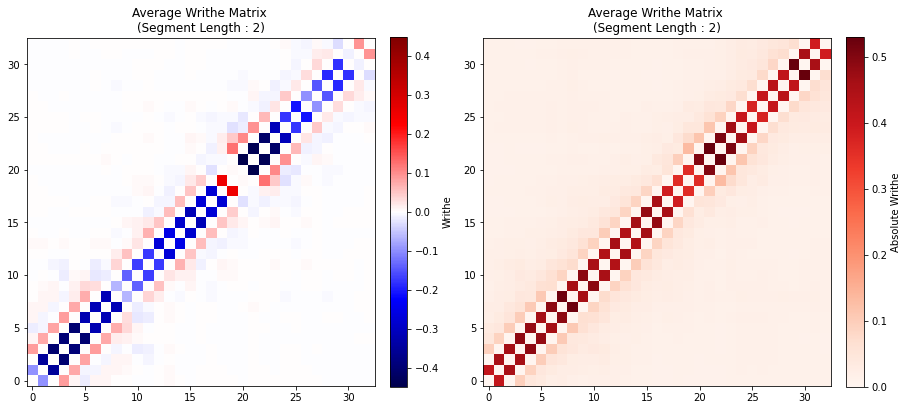

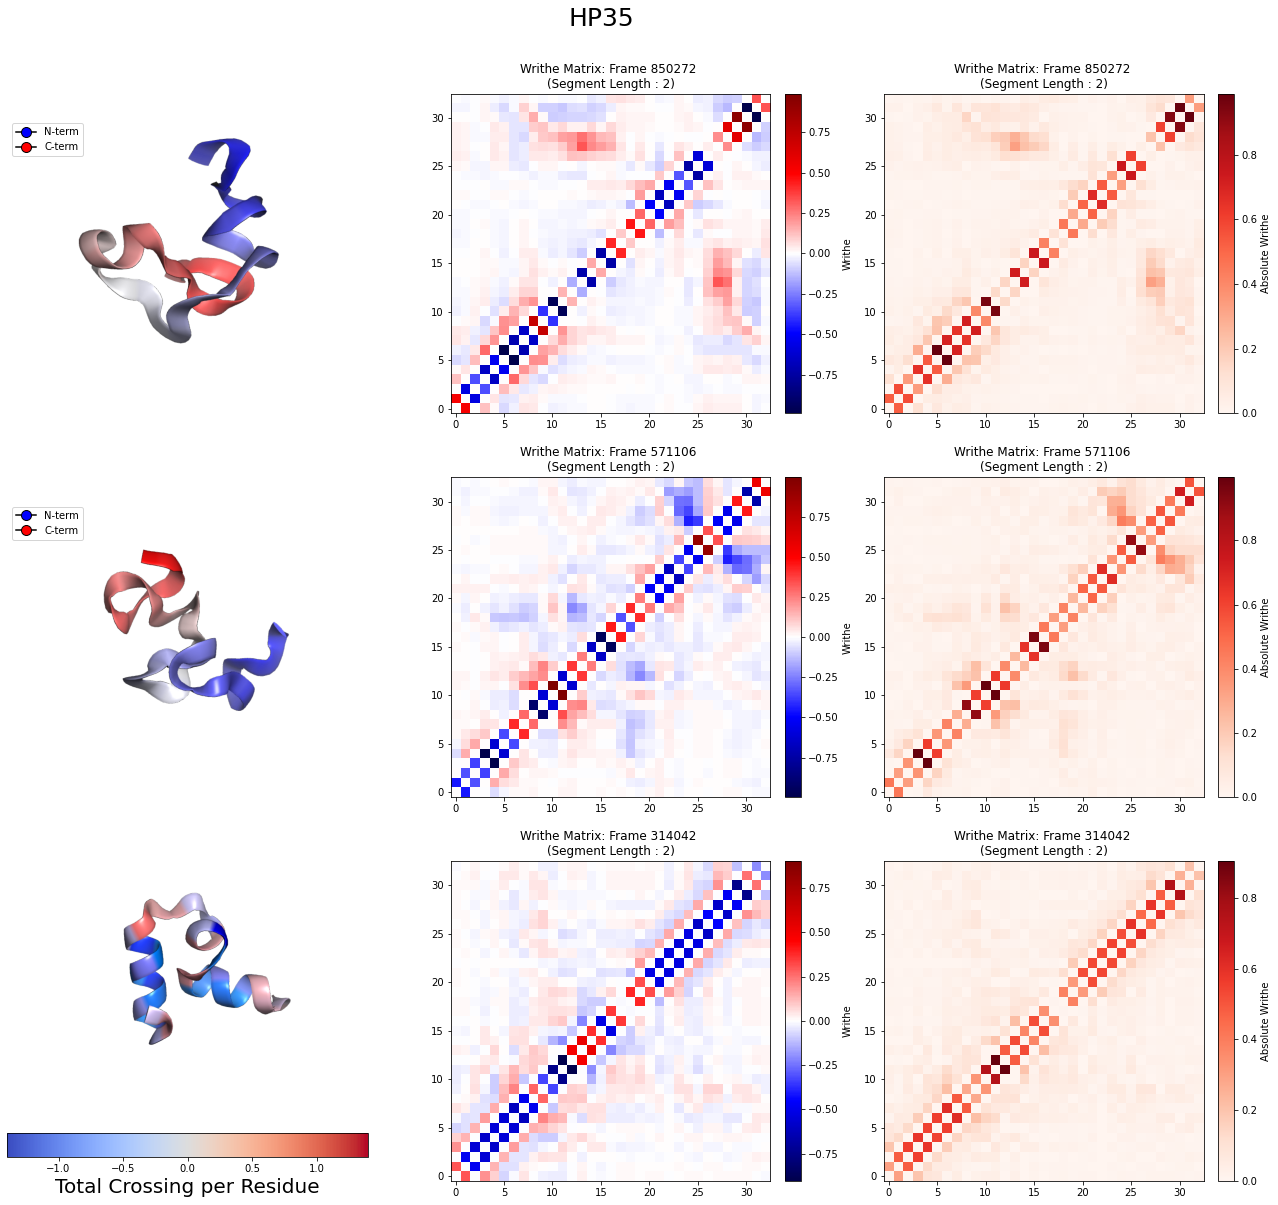

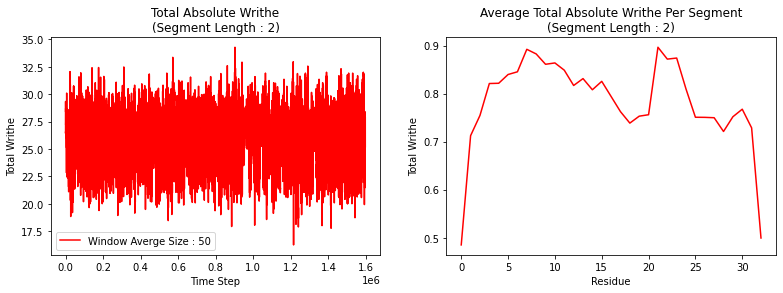

In [4]:
for data_file, length in zip(writhe_data_files[1:], lengths[1:]):
    #restore the writhe class to make plotting easy
    writhe_features = np.load(data_file)
    
    writhe = Writhe(**{"n":trj.n_frames,
                       "n_points":len(trj.topology.select("name CA")),
                       "length":length,
                       "writhe_features":writhe_features,
                      })
    
    #compute the square matrix
    writhe.writhe_matrix = writhe.make_writhe_matrix()
    
    #start plotting
    fig, axes = plt.subplots(1,2,figsize=(15,13))
    ax=axes.flat
    
    #plot the average 
    writhe.plot_writhe_matrix(ax=ax[0])
    
    #plot the absolute value average
    writhe.plot_writhe_matrix(absolute=True, ax=ax[1])

    #plot the writhe matrix at different timesteps
    fig,axes=plt.subplots(3,3, figsize=(22,20))

    #find iteresting frames
    idx=abs(writhe.writhe_features).sum(1).argsort()[::-1].astype(int)
    indices = list(map(idx.__getitem__, [1000,20]))
    
    indices +=[314042]

    #plot structures and writhe matrices
    fig.suptitle(protein_name, fontsize=25, y=.94)
    for ax, index in zip(axes[:-1], indices[:-1]):
        structure=visualize.make_structures(trj=trj,
                                            indices=int(index),
                                            dir=f"{out_dir}/images",
                                            ref = pdb,
                                            overwrite=True)
        
        visualize.plot_structure(image=structure, ax=ax[0])
        writhe.plot_writhe_matrix(index=index, ax=ax[1])
        writhe.plot_writhe_matrix(index=index, ax=ax[2], absolute=True)
    
    
    beta_values = to_writhe_adj_matrix(
        writhe_features=np.expand_dims(writhe.writhe_features[indices[-1]],0),
        n_points=writhe.n_points,
        length=writhe.length,
        n=1).squeeze().sum(0)
        
    bound = max(abs(beta_values.min()),beta_values.max())
    structure=visualize.make_structures(trj=trj,
                                        indices=int(indices[-1]),
                                        dir=f"{out_dir}/images",
                                        beta_values=beta_values,
                                        beta_min=-bound,
                                        beta_max=bound,
                                        overwrite=True,
                                        palette=visualize.palettes["coolwarm"],
                                        ref=pdb)
    
    
    
    im=visualize.plot_structure(image=structure,
                                ax=axes[-1,0],
                                legend=False,
                                vmin=-bound,
                                vmax=bound)
    
    cmap = getattr(plt.cm, "coolwarm")
    norm = matplotlib.colors.Normalize(vmin=beta_values.min(), vmax=beta_values.max())
    cbar = fig.colorbar(im,ax=axes[-1,0],
                        cmap=cmap, norm=norm, 
                        orientation = "horizontal",
                        aspect=15)
    cbar.set_label("Total Crossing per Residue", size = 20) 

    
    writhe.plot_writhe_matrix(index=indices[-1], ax=axes[-1,1])
    writhe.plot_writhe_matrix(index=indices[-1], ax=axes[-1,2], absolute=True)
    

    #plot the total absolute writhe in a time series with a windowed average
    fig, axes = plt.subplots(1,2,figsize=(13,4))
    ax=axes.flat
    writhe.plot_writhe_total(window=50,ax=ax[0])
    #plot the average absolute writhe per segment
    writhe.plot_writhe_per_segment(ax=ax[1])
    break

del writhe

/tmp/ipykernel_336/1801860048.py:84: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(1,2,figsize=(13,4))


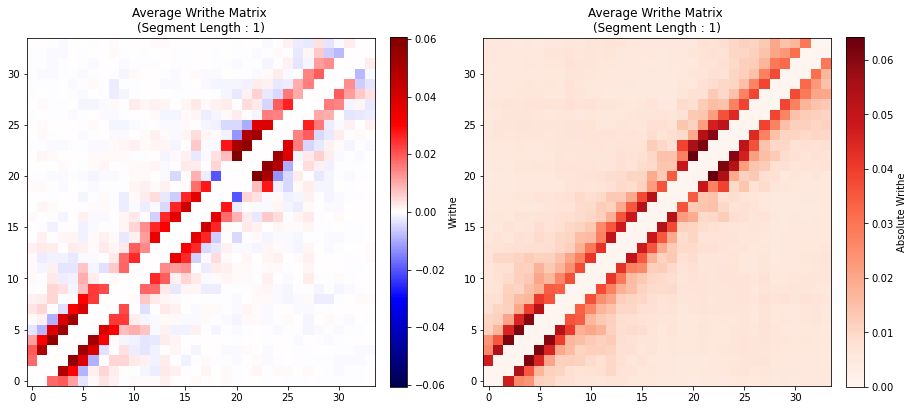

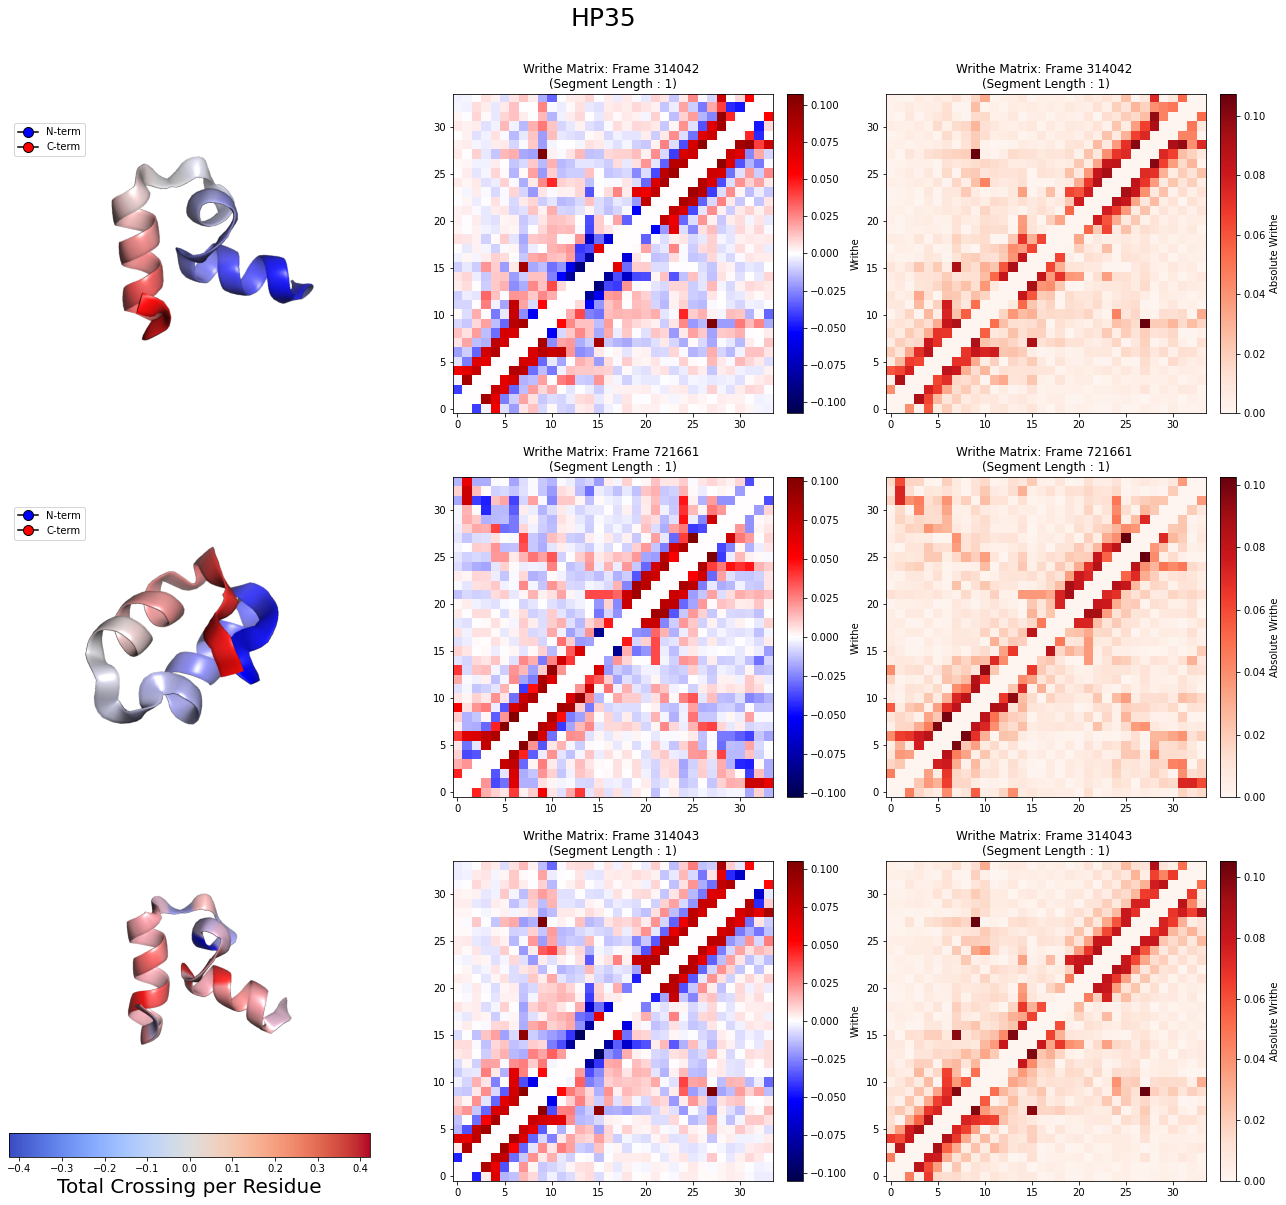

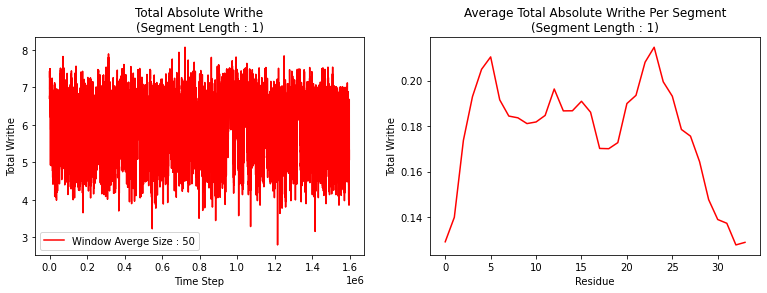

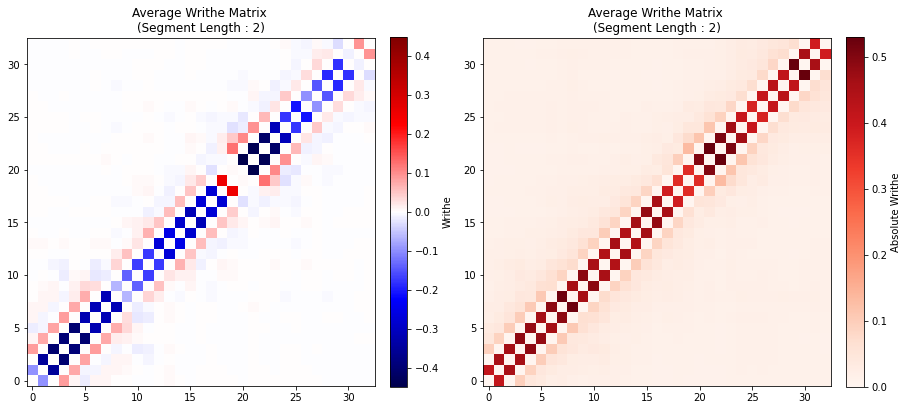

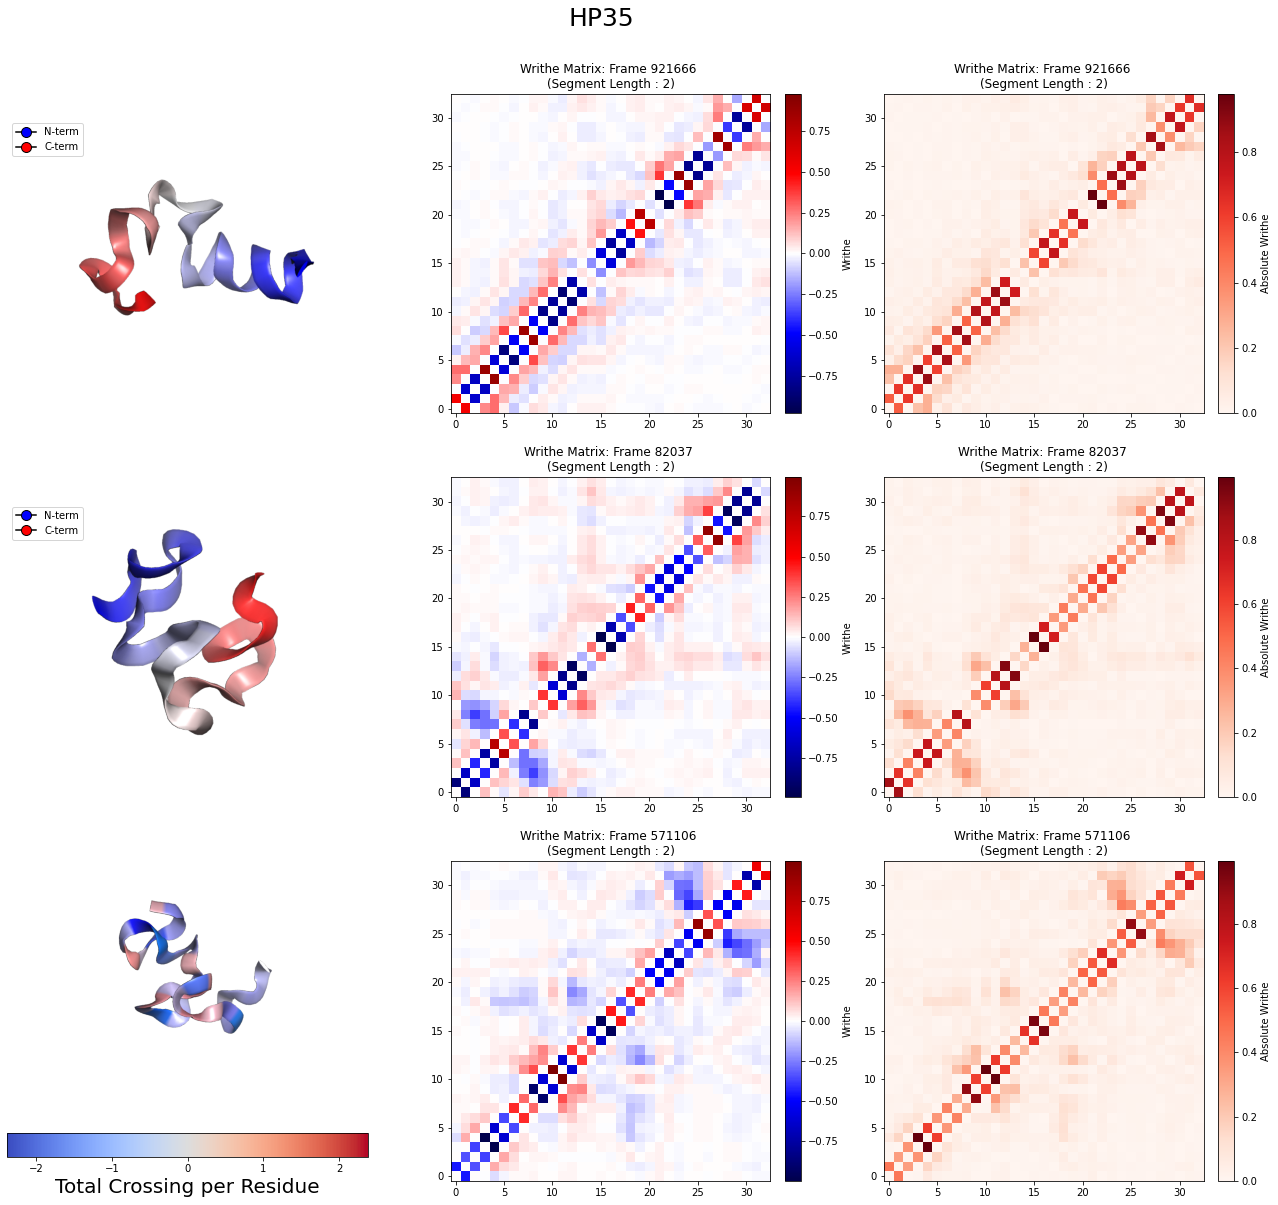

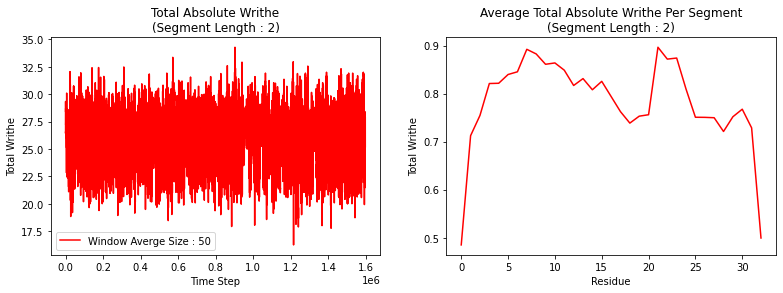

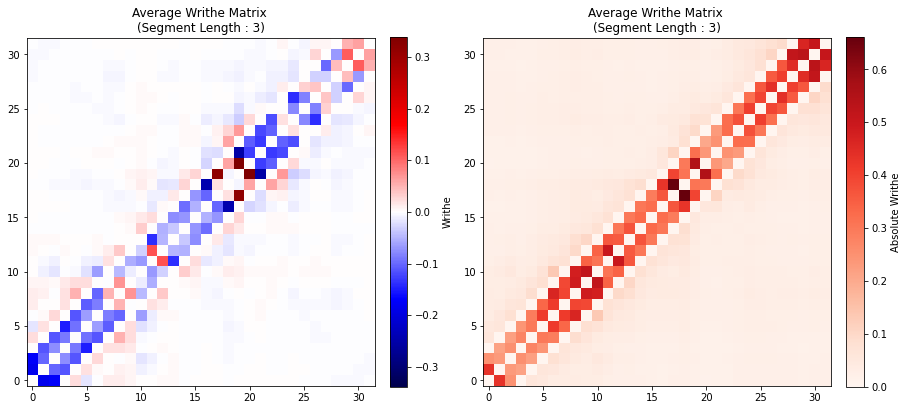

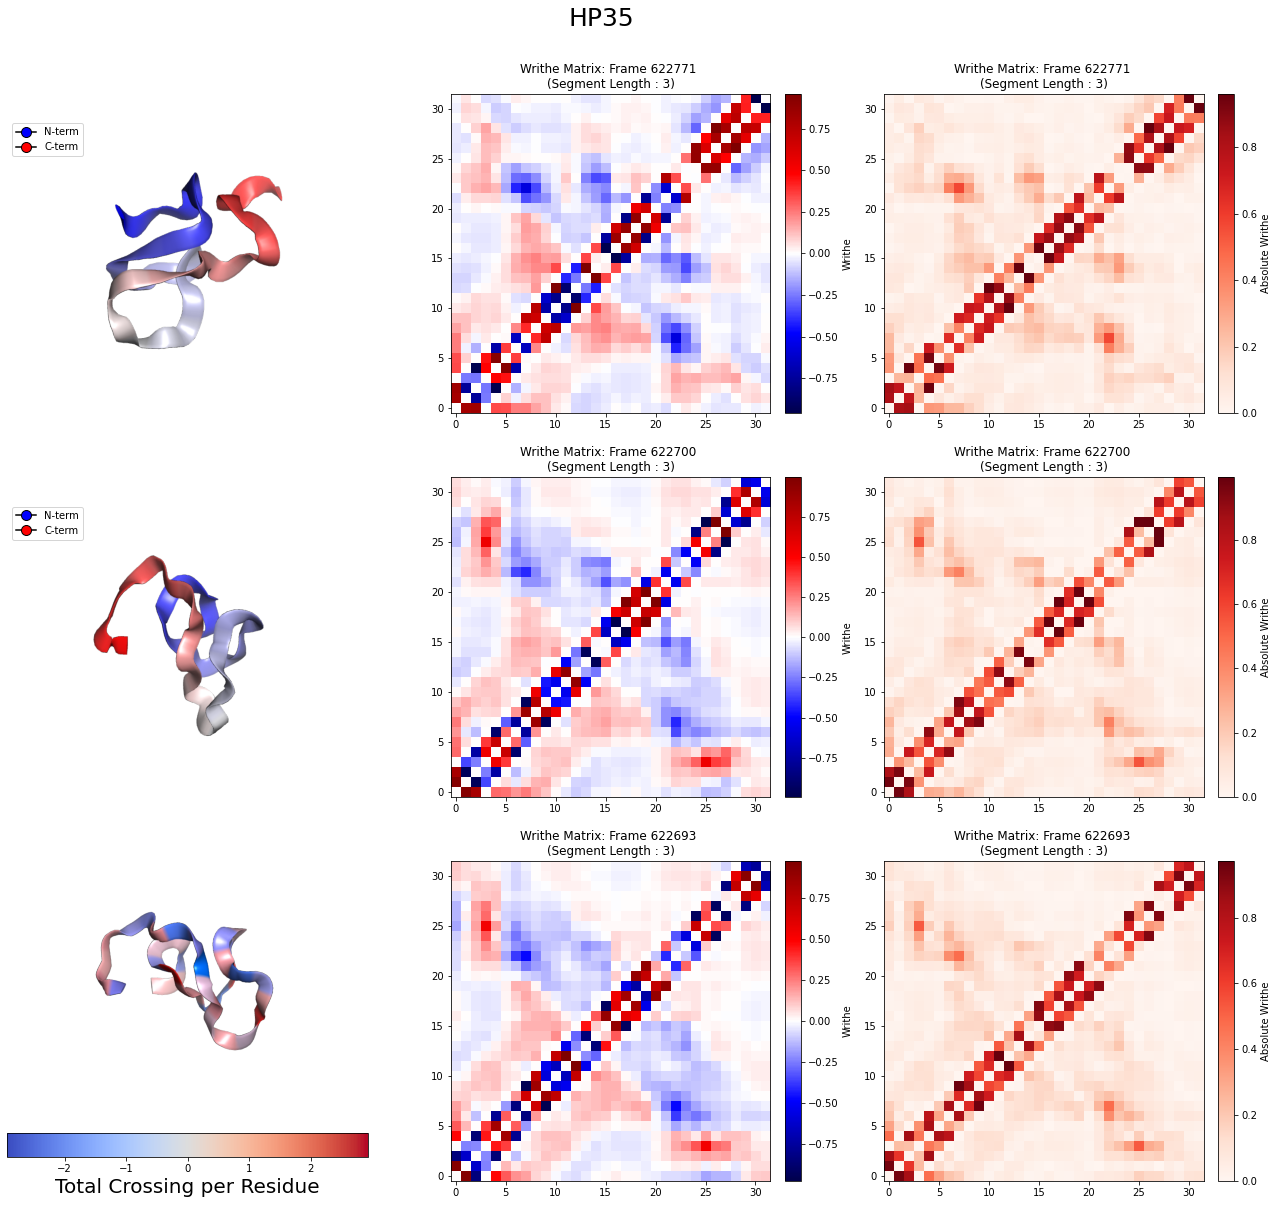

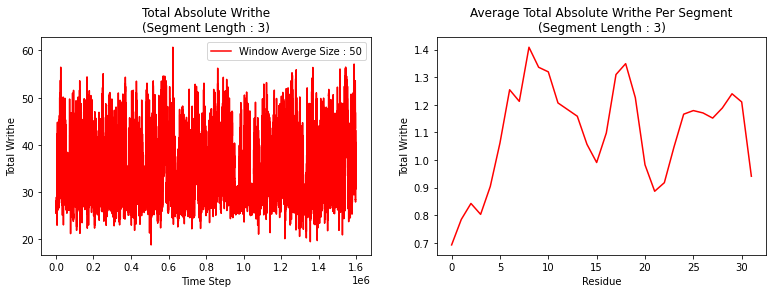

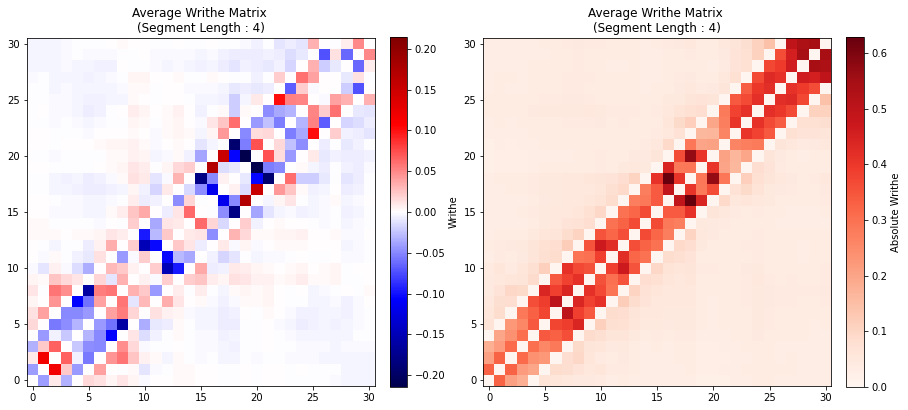

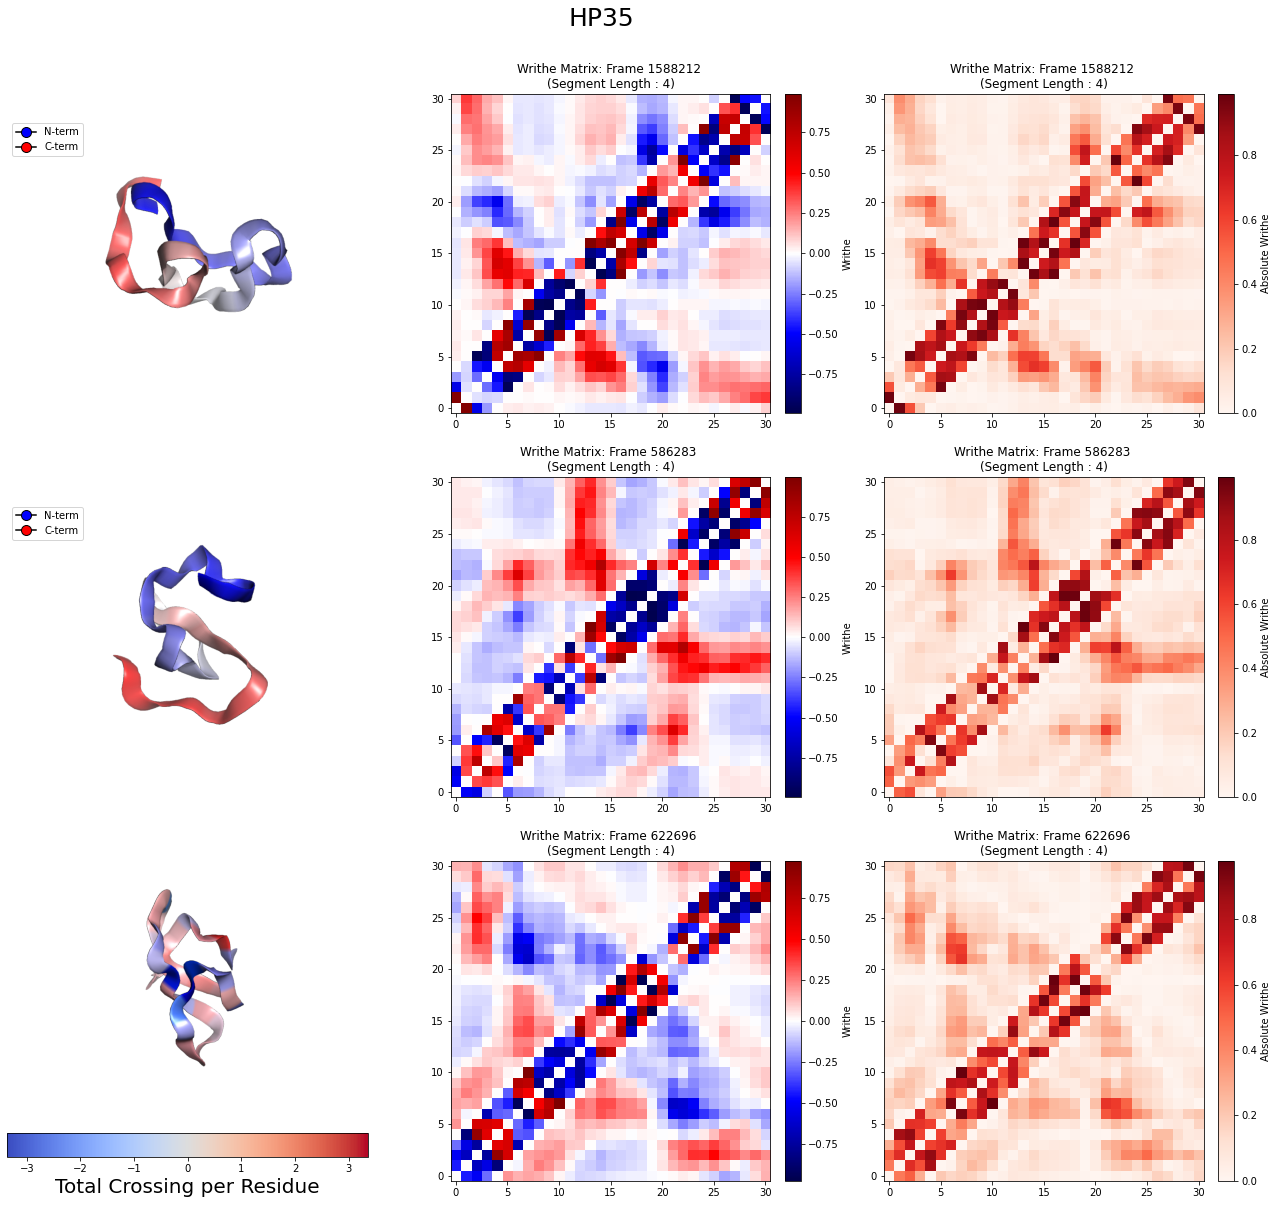

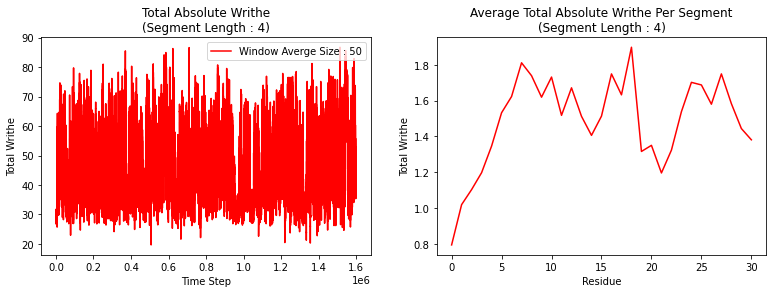

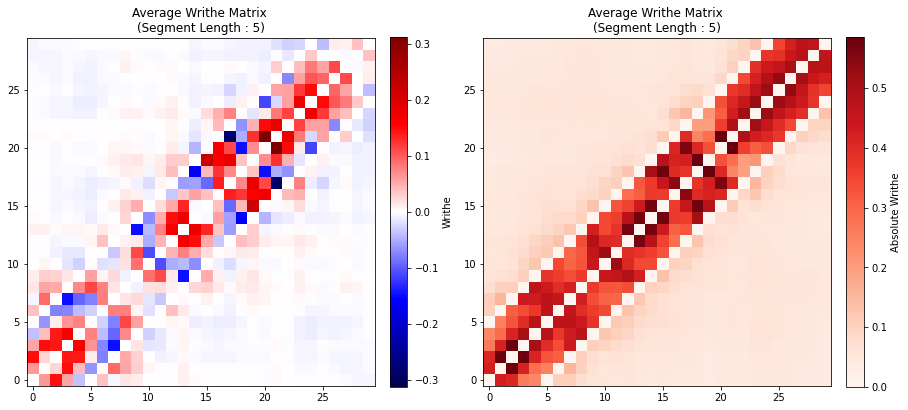

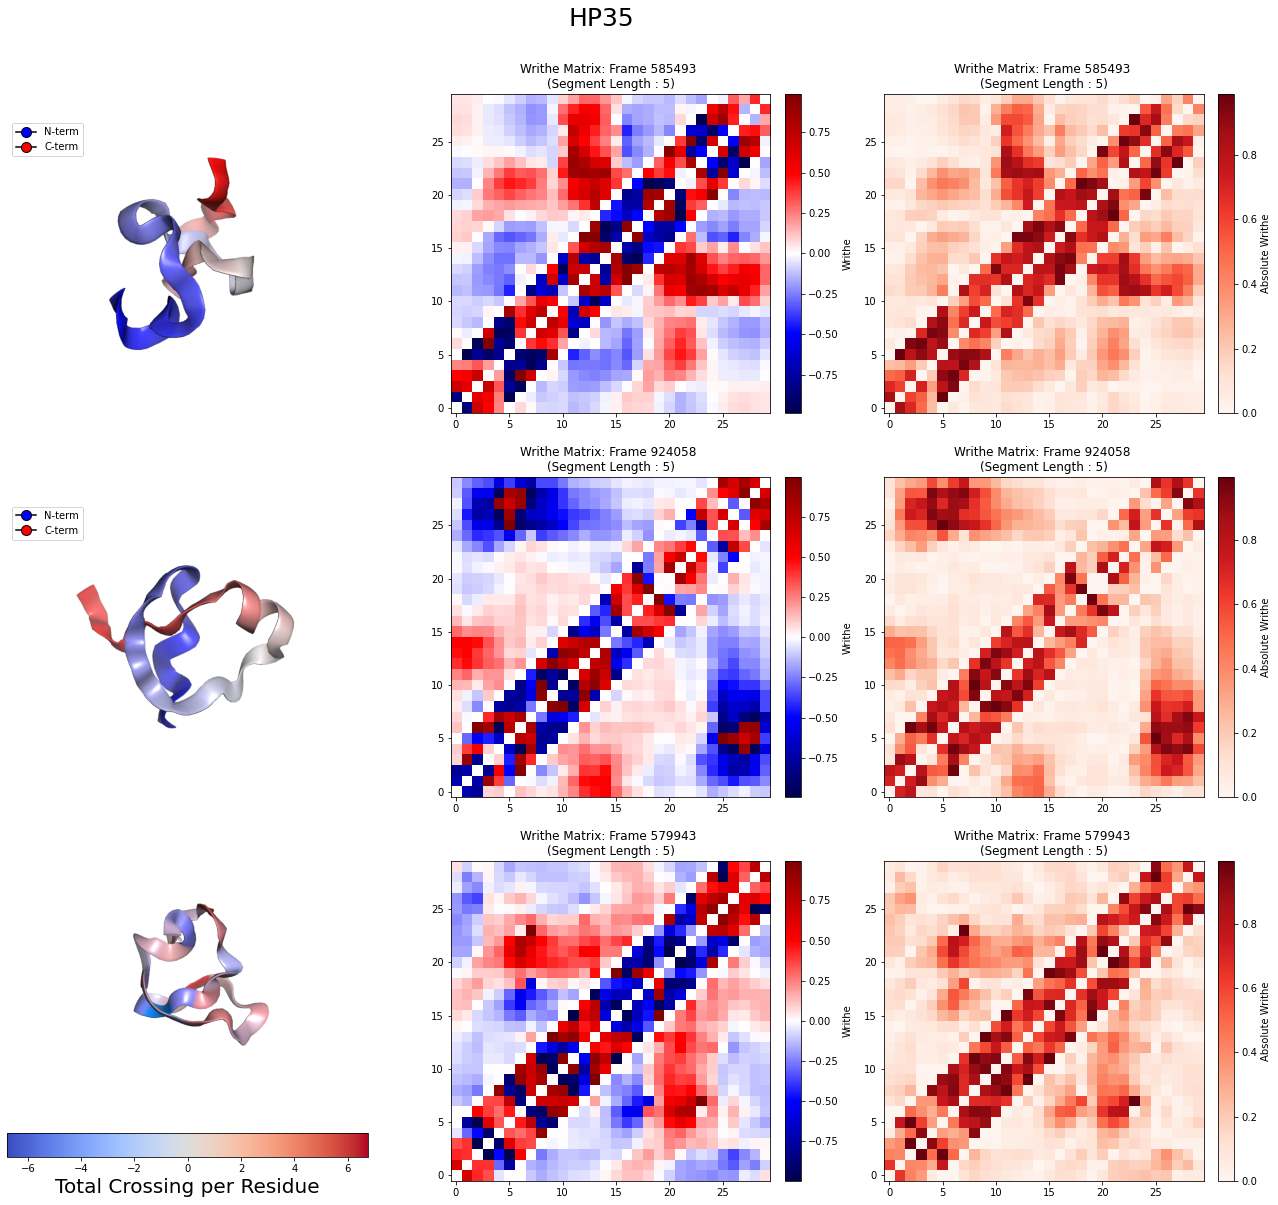

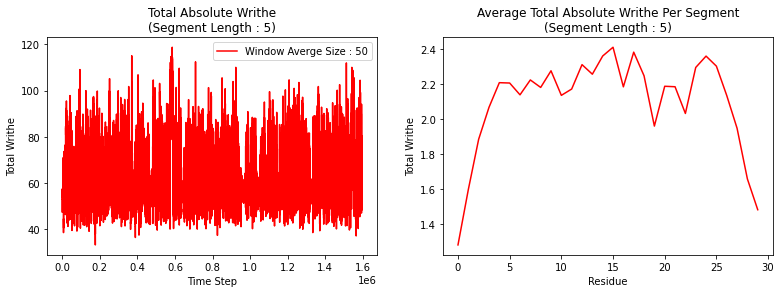

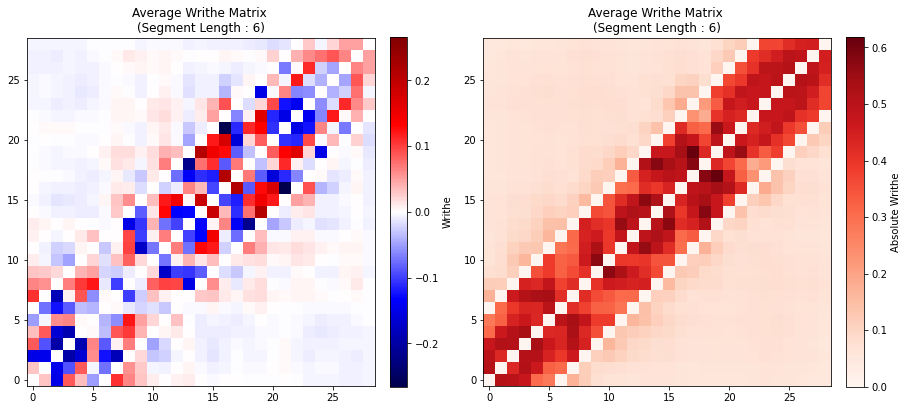

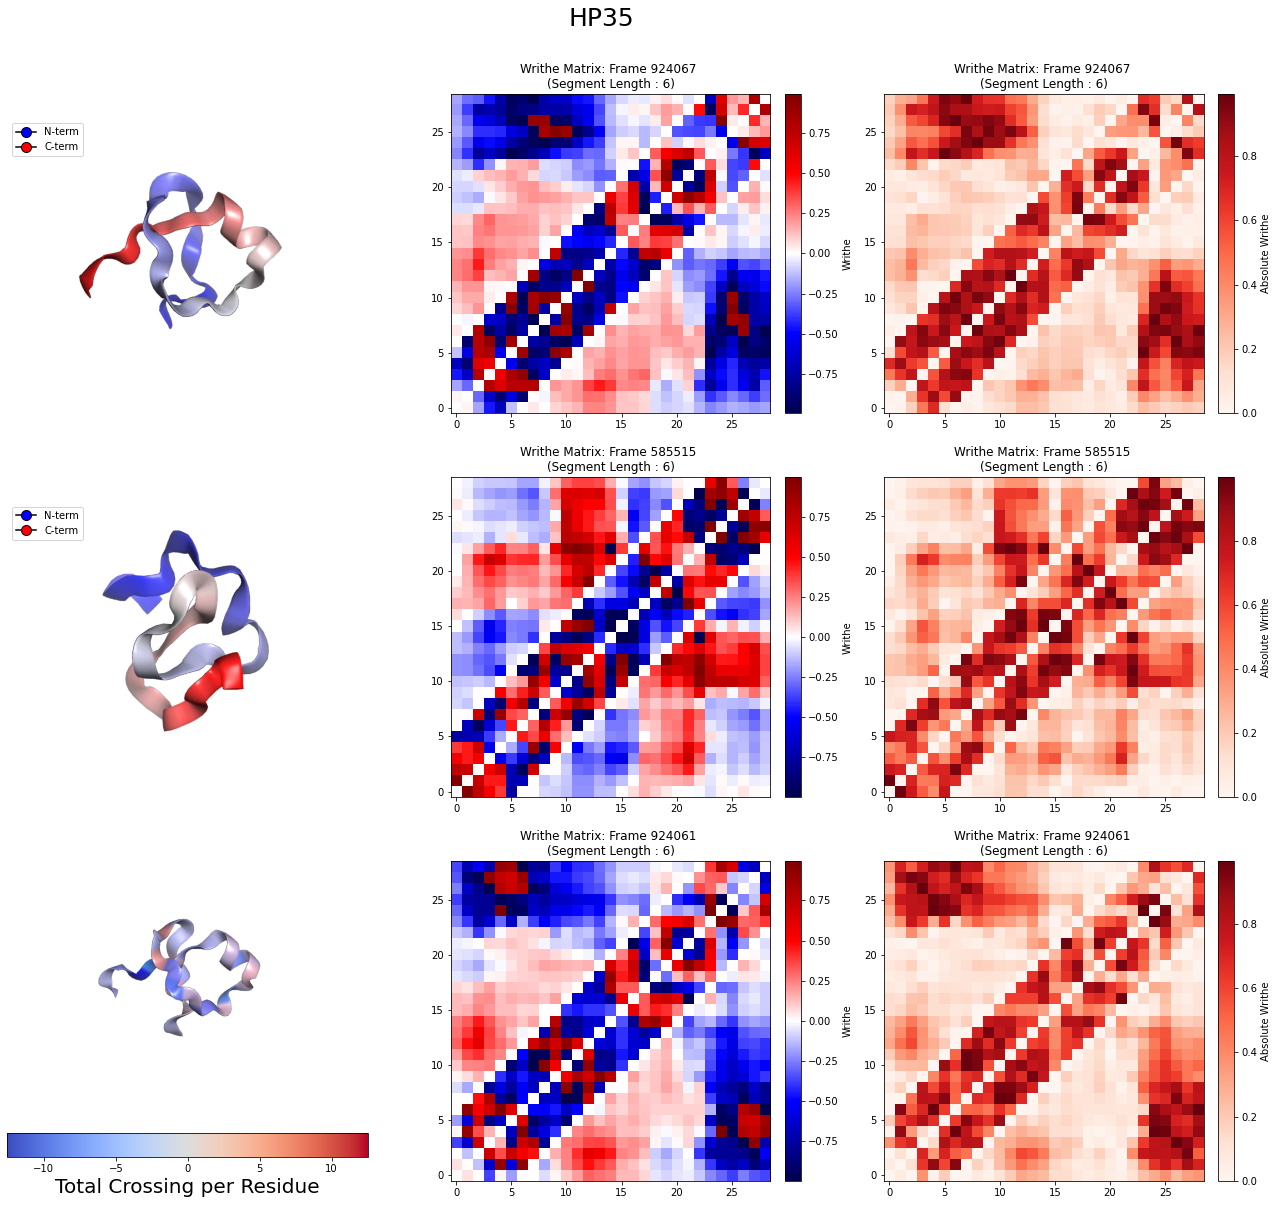

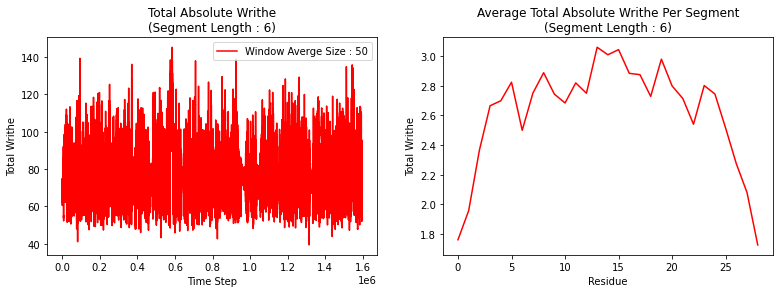

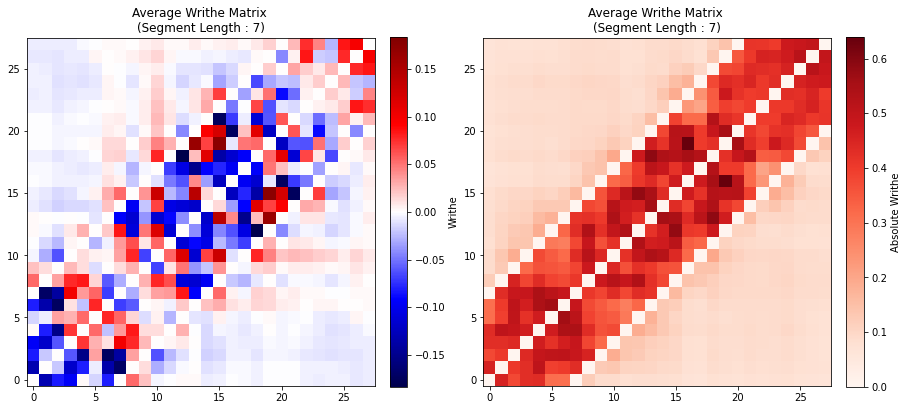

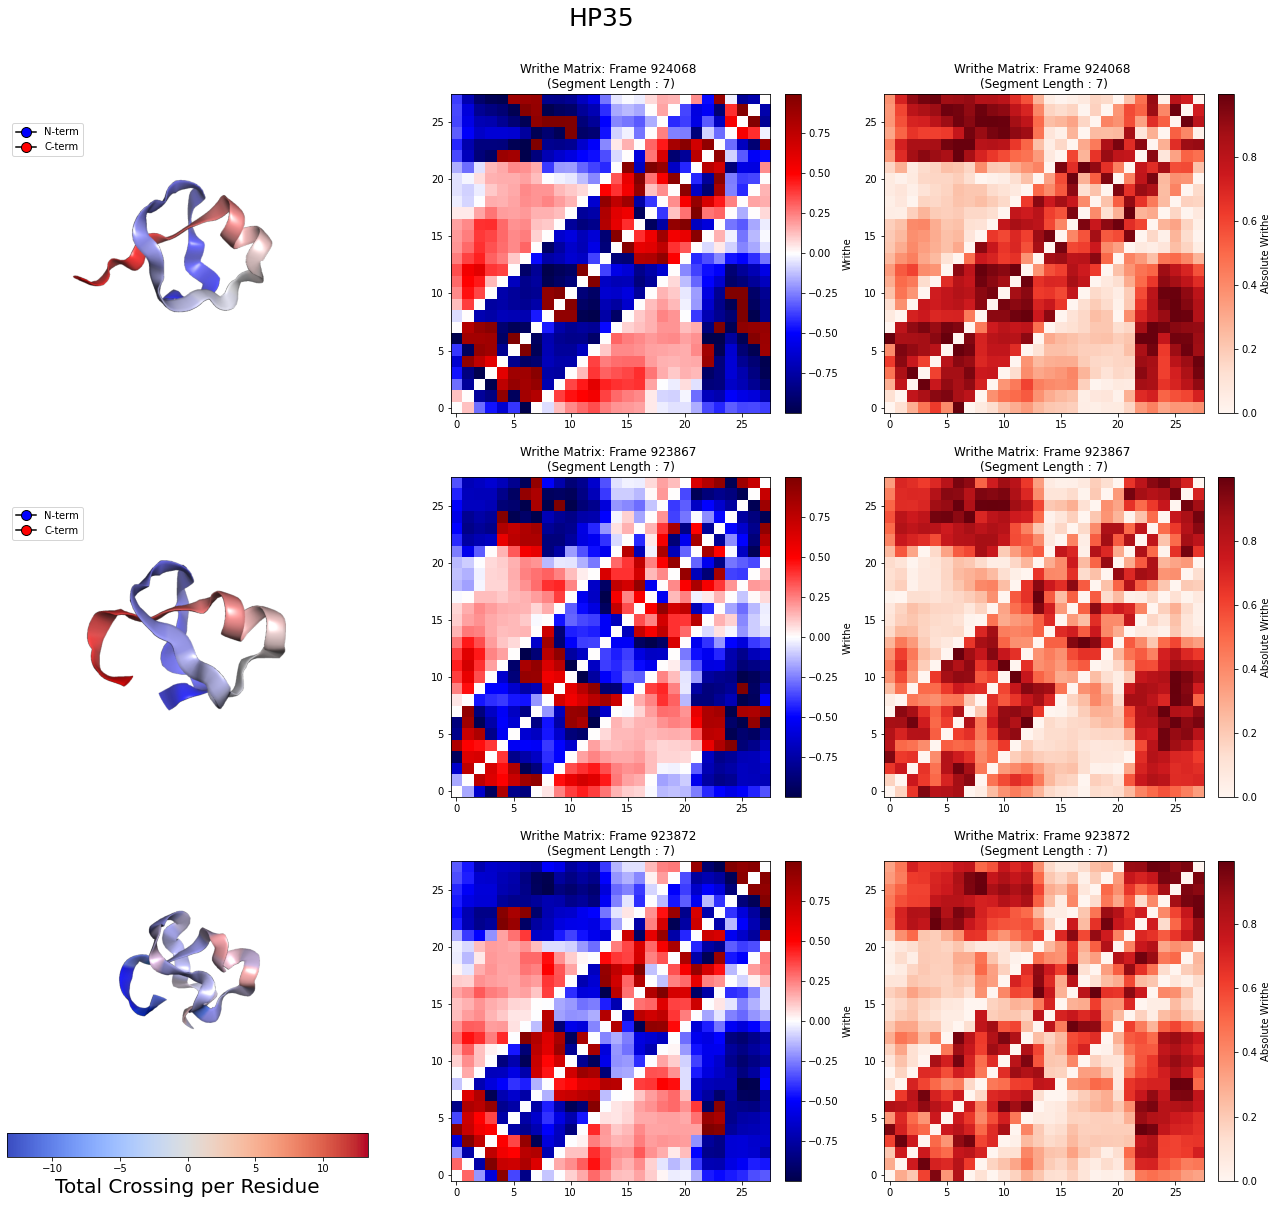

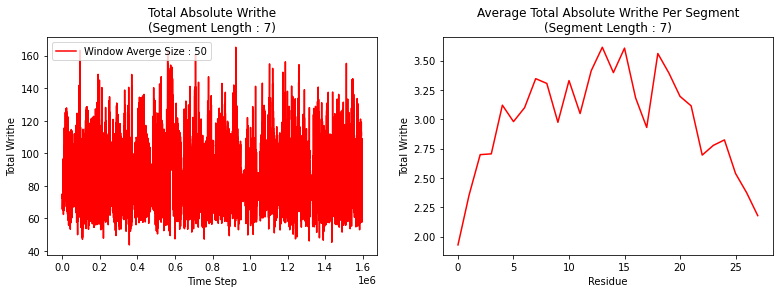

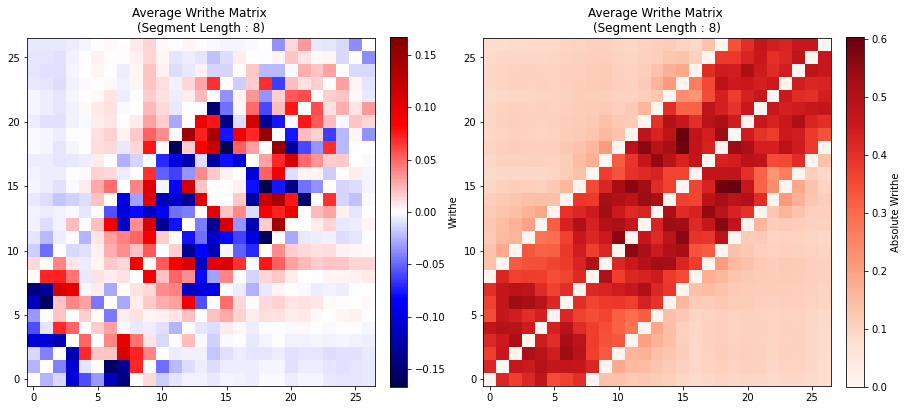

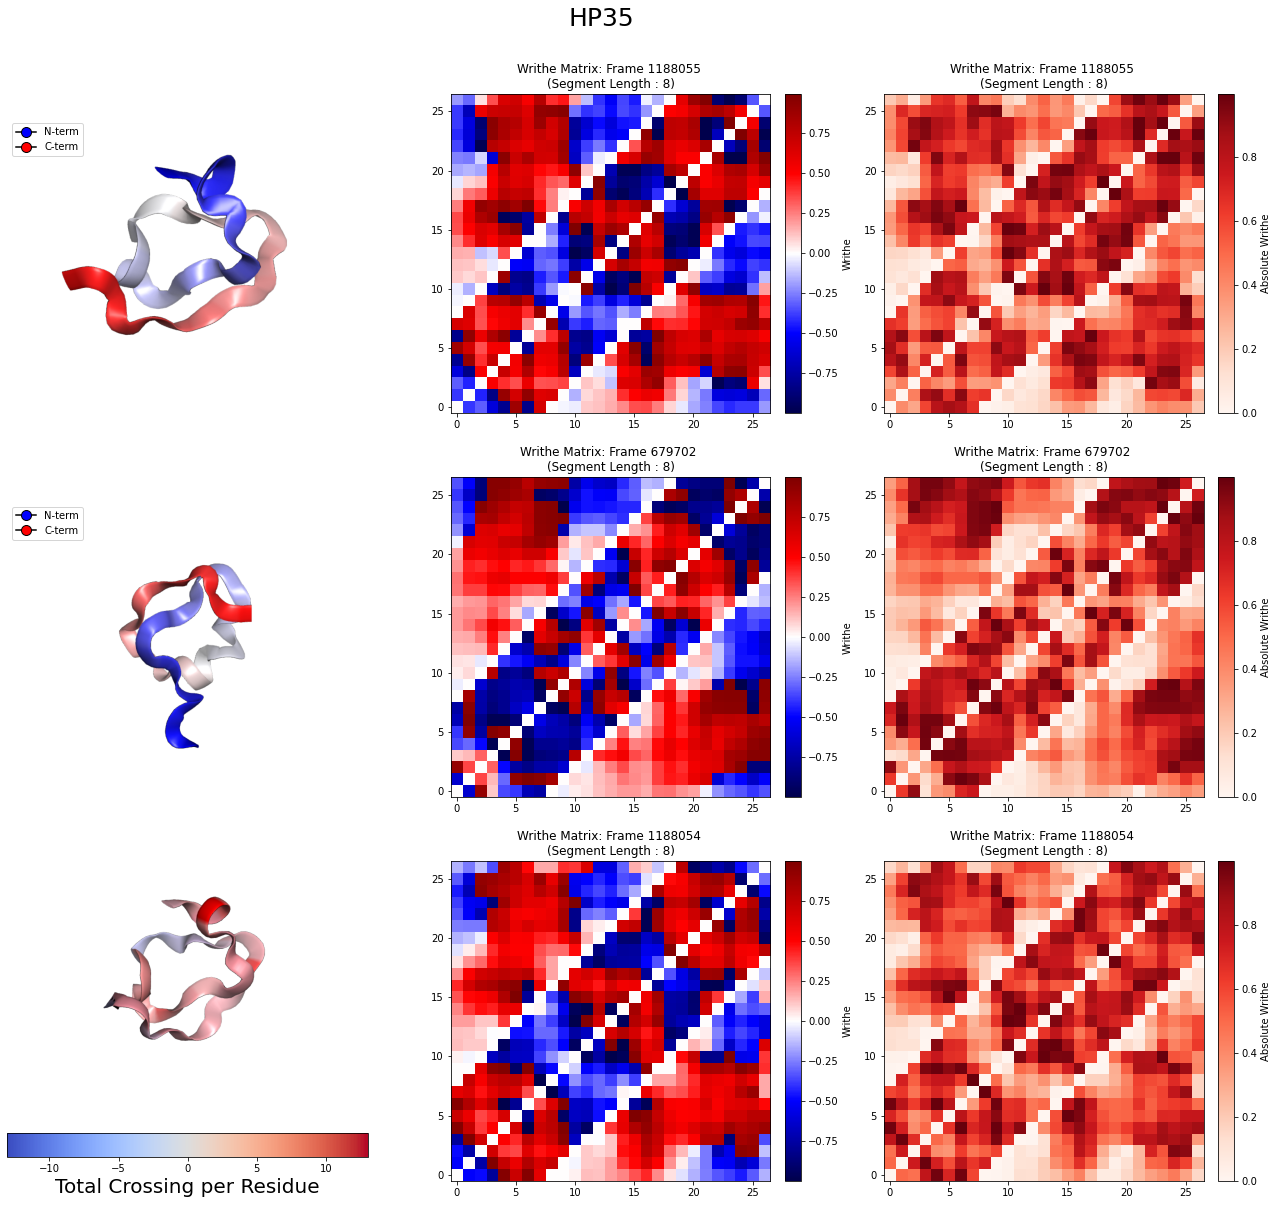

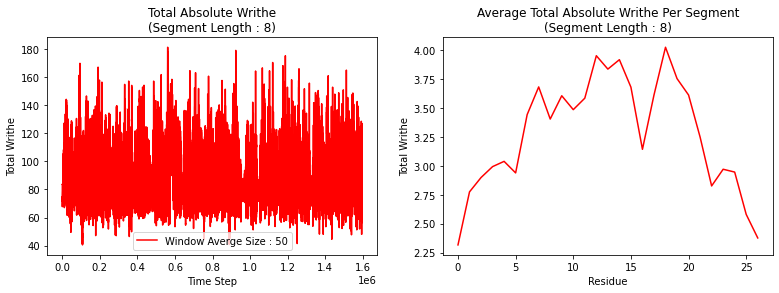

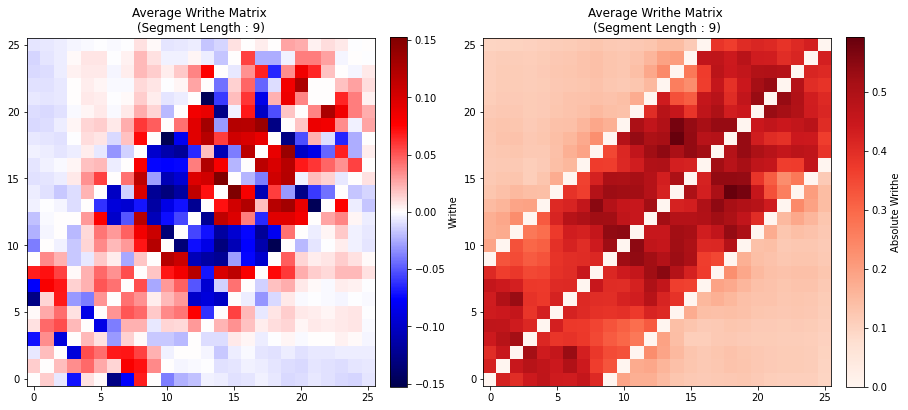

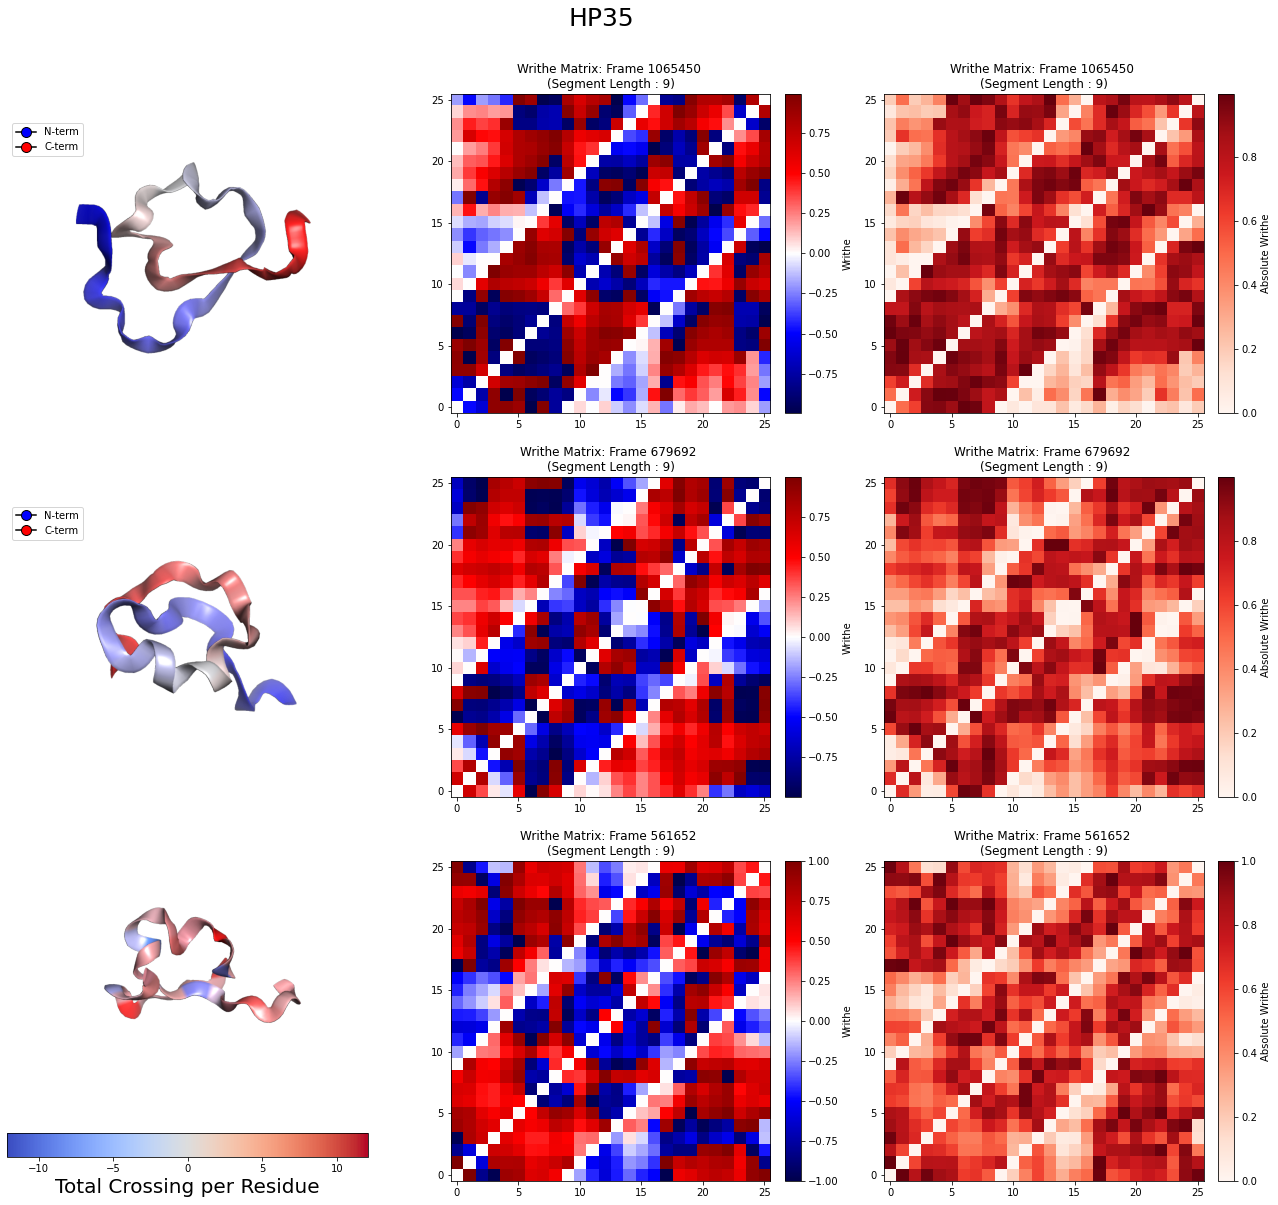

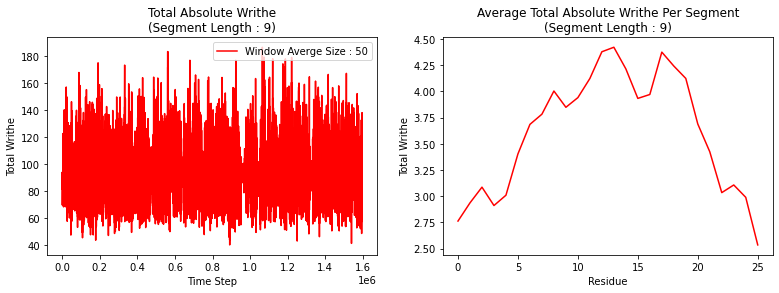

In [4]:
for data_file, length in zip(writhe_data_files, lengths):
    #restore the writhe class to make plotting easy
    writhe_features = np.load(data_file)
    
    writhe = Writhe(**{"n":trj.n_frames,
                       "n_points":len(trj.topology.select("name CA")),
                       "length":length,
                       "writhe_features":writhe_features,
                      })
    
    #compute the square matrix
    writhe.writhe_matrix = writhe.make_writhe_matrix()
    
    #start plotting
    fig, axes = plt.subplots(1,2,figsize=(15,13))
    ax=axes.flat
    
    #plot the average 
    writhe.plot_writhe_matrix(ax=ax[0])
    
    #plot the absolute value average
    writhe.plot_writhe_matrix(absolute=True, ax=ax[1])

    #plot the writhe matrix at different timesteps
    fig,axes=plt.subplots(3,3, figsize=(22,20))

    #find iteresting frames
    idx=abs(writhe.writhe_features).sum(1).argsort()[::-1].astype(int)
    indices = list(map(idx.__getitem__, [0, 10, 20]))

    #plot structures and writhe matrices
    fig.suptitle(protein_name, fontsize=25, y=.94)
    for ax, index in zip(axes[:-1], indices[:-1]):
        structure=visualize.make_structures(trj=trj,
                                            indices=int(index),
                                            dir=f"{out_dir}/images",
                                            ref = pdb,
                                            overwrite=True)
        
        visualize.plot_structure(image=structure, ax=ax[0])
        writhe.plot_writhe_matrix(index=index, ax=ax[1])
        writhe.plot_writhe_matrix(index=index, ax=ax[2], absolute=True)
    
    
    beta_values = to_writhe_adj_matrix(
        writhe_features=np.expand_dims(writhe.writhe_features[indices[-1]],0),
        n_points=writhe.n_points,
        length=writhe.length,
        n=1).squeeze().sum(0)
        
    bound = max(abs(beta_values.min()),beta_values.max())
    structure=visualize.make_structures(trj=trj,
                                        indices=int(indices[-1]),
                                        dir=f"{out_dir}/images",
                                        beta_values=beta_values,
                                        beta_min=-bound,
                                        beta_max=bound,
                                        overwrite=True,
                                        palette=visualize.palettes["coolwarm"],
                                        ref=pdb)
    
    
    
    im=visualize.plot_structure(image=structure,
                                ax=axes[-1,0],
                                legend=False,
                                vmin=-bound,
                                vmax=bound)
    
    cmap = getattr(plt.cm, "coolwarm")
    norm = matplotlib.colors.Normalize(vmin=beta_values.min(), vmax=beta_values.max())
    cbar = fig.colorbar(im,ax=axes[-1,0],
                        cmap=cmap, norm=norm, 
                        orientation = "horizontal",
                        aspect=15)
    cbar.set_label("Total Crossing per Residue", size = 20) 

    
    writhe.plot_writhe_matrix(index=indices[-1], ax=axes[-1,1])
    writhe.plot_writhe_matrix(index=indices[-1], ax=axes[-1,2], absolute=True)
    

    #plot the total absolute writhe in a time series with a windowed average
    fig, axes = plt.subplots(1,2,figsize=(13,4))
    ax=axes.flat
    writhe.plot_writhe_total(window=50,ax=ax[0])
    #plot the average absolute writhe per segment
    writhe.plot_writhe_per_segment(ax=ax[1])

del writhe

Text(0.5, 0.96, 'HP35')

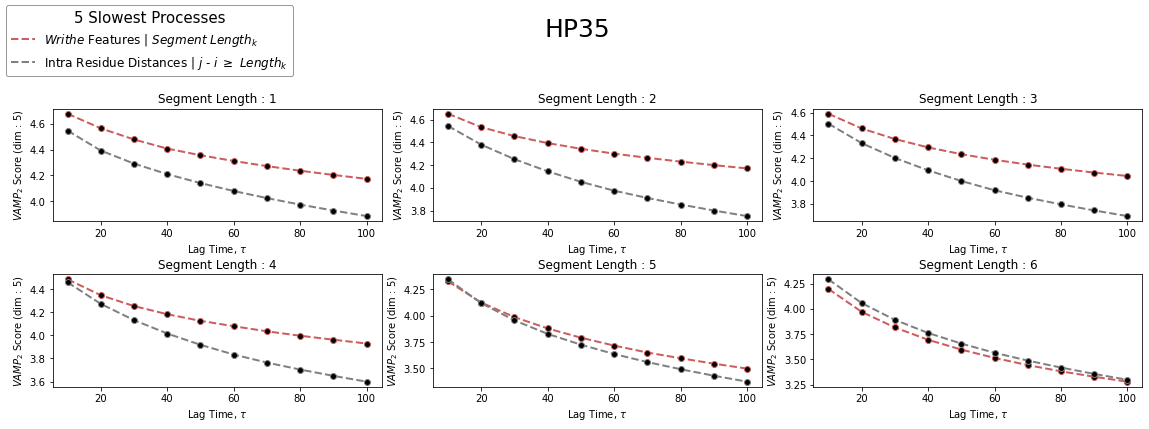

In [5]:
from matplotlib.lines import Line2D
fig,axes=plt.subplots(2,3,figsize=(16,6))

for ax, writhe_score, distance_score, length in zip(axes.flat,
                                                    writhe_scores.sum(-1),
                                                    distance_scores.sum(-1),
                                                    lengths):   
    ax.plot(lags,writhe_score,
             label=f"Writhe (Segment Length : {length})",
             color="indianred",
             lw=2,
             ls="--",
             marker="o",
             mfc="black")
    
    
    ax.plot(lags,distance_score,
             label=f"Intra Residue Distances, $j$ - $i$ $\geq$ {length}",
             color="gray",
             lw=2,
             ls="--",
             marker="o",
             mfc="black")
    
    ax.set_ylabel("$VAMP_{2}$ Score (dim : 5)")
    ax.set_xlabel(r"Lag Time, $\tau$")
    ax.set_title(f"Segment Length : {length}")


    fig.suptitle(protein_name, fontsize=25, y=.96)

legend_elements = [Line2D([0], [0], color='indianred',
                          label="$Writhe$ Features | $Segment$ $Length_{k}$",
                          markersize=10, lw=2, ls="--"),
                   
                   Line2D([0], [0], color='gray',
                          label='Intra Residue Distances | $j$ - $i$ $\geq$ $Length_{k}$',
                          markersize=10, lw=2, ls="--")]

fig.legend(handles=legend_elements,title=f"{5} Slowest Processes",loc="upper left",
          fontsize=12, title_fontsize=15, edgecolor=(.5,.5,.5))

plt.tight_layout()
plt.subplots_adjust(top=.75)
    
fig.suptitle(protein_name, fontsize=25, y=.96)

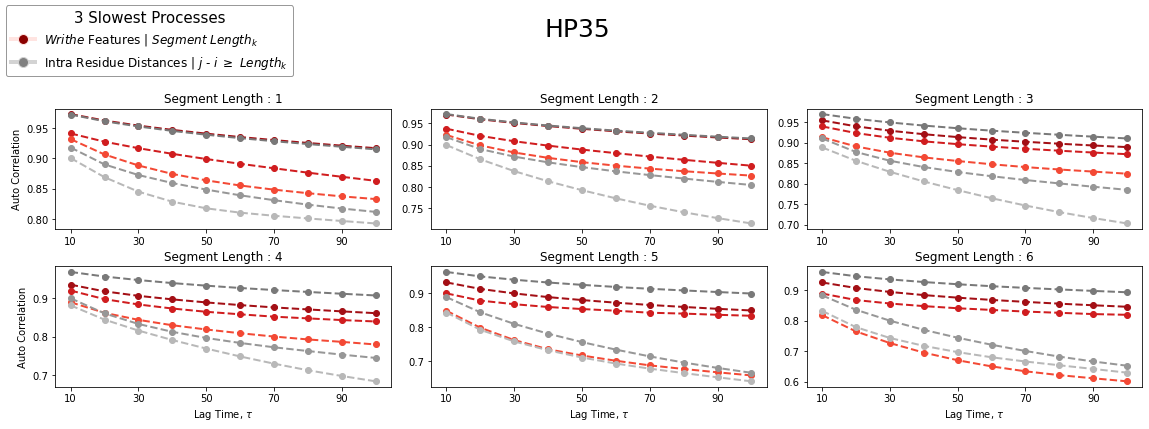

In [6]:
from cycler import cycler
n_procs=3

from matplotlib.lines import Line2D
fig,axes=plt.subplots(2,3,figsize=(16,6))
n_procs=3
  
for ax, writhe_score, distance_score, length in zip(axes.flat,
                                                    writhe_scores,
                                                    distance_scores,
                                                    lengths): 
    
    ax.set_prop_cycle((cycler(color=visualize.get_color_list(n_procs,"Reds_r",trunc=150,pre_trunc=30)
                             )))
    
    ax.plot(writhe_score[:,:n_procs],
             label=f"Writhe (Segment Length : {length})",
             lw=2,
             ls="--",
             marker="o")
    
    
    ax.set_prop_cycle((cycler(color=visualize.get_color_list(n_procs,"Greys_r",trunc=100, pre_trunc=100)
                             )))
    
    ax.plot(distance_score[:,:n_procs],
             label=f"Writhe Features (Segment Length : {length})",
             lw=2,
             ls="--",
             marker="o")
    
    ax.set_xticks(range(0,len(lags),2),lags[::2])

    ax.set_title(f"Segment Length : {length}")


for ax in axes[:,0]:
    ax.set_ylabel("Auto Correlation")
for ax in axes[-1]:
    ax.set_xlabel(r"Lag Time, $\tau$")
    

fig.suptitle(protein_name, fontsize=25, y=.96)

legend_elements = [Line2D([0], [0], marker="o", color='mistyrose',
                          label="$Writhe$ Features | $Segment$ $Length_{k}$",
                          markerfacecolor="darkred", markersize=10, lw=4),
                   Line2D([0], [0], marker="o", color='lightgray',
                          label='Intra Residue Distances | $j$ - $i$ $\geq$ $Length_{k}$',
                          markerfacecolor="gray", markersize=10,lw=4)]

fig.legend(handles=legend_elements,title=f"{n_procs} Slowest Processes",loc="upper left",
          fontsize=12, title_fontsize=15, edgecolor=(.5,.5,.5))

plt.tight_layout()
plt.subplots_adjust(top=.75)

Text(0.5, 1.0, 'HP35')

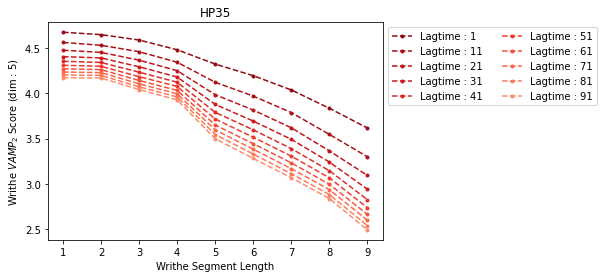

In [7]:
#scores=np.stack([dic["scores"].sum(-1) for dic in writhe_datasets.values()])

for score,label,color in zip(writhe_scores.transpose(1,0,2).sum(-1),
                             [f"Lagtime : {lag}" for lag in range(1,102,10)],
                             visualize.get_color_list(len(lags),"Reds_r",pre_trunc=20,
                                                      trunc=100)):
    
    plt.plot(lengths,
             score,
             color=color,
             label=label,
             ls="--",
             marker="o",
             ms=3,)
#              mfc="black",
#              mec="black")
    
    
plt.xticks(range(1,lengths[-1]+1))
plt.ylabel("Writhe $VAMP_{2}$ Score (dim : 5)")
plt.xlabel(r"Writhe Segment Length")
plt.legend(bbox_to_anchor=(1, 1), loc='upper left',ncol=2)
plt.title(protein_name)

In [8]:
import functools
rm_path = lambda x : x.split("/")[-1]

def anymatch(string, strings, rm_path_=True):
    
    if rm_path_:
        string = rm_path(string)
        
    
    return any(map(string.count,iter(strings)))


def itermatch(string,strings,rm_path=True):
    
    func = functools.partial(anymatch, strings=strings)
    return list(filter(func,string))
    
whiten = lambda x : (x - x.mean(0)) / x.std(0)
    

In [88]:
combined_tcca_12 = np.stack(list(map(np.load,
                                  utils.lsdir(writhe_data_dir+"/combined_12",
                                              keyword=["combined", "lag"],
                                              exclude="singular"))))

combined_tcca_scores_12 = np.array(list(map(np.load, utils.lsdir(writhe_data_dir+"/combined_12",
                                                              "singular"))))


combined_tcca_123 = np.stack(list(map(np.load,
                                  utils.lsdir(writhe_data_dir+"/combined_123",
                                              keyword=["combined", "lag"],
                                              exclude="singular"))))

combined_tcca_scores_123 = np.array(list(map(np.load, utils.lsdir(writhe_data_dir+"/combined_123",
                                                              "singular"))))

combined_tcca_1234 = np.stack(list(map(np.load,
                                  utils.lsdir(writhe_data_dir+"/combined_1234",
                                              keyword=["combined", "lag"],
                                              exclude="singular"))))

combined_tcca_scores_1234 = np.array(list(map(np.load, utils.lsdir(writhe_data_dir+"/combined_1234",
                                                              "singular"))))

Text(0.5, 0.96, 'HP35')

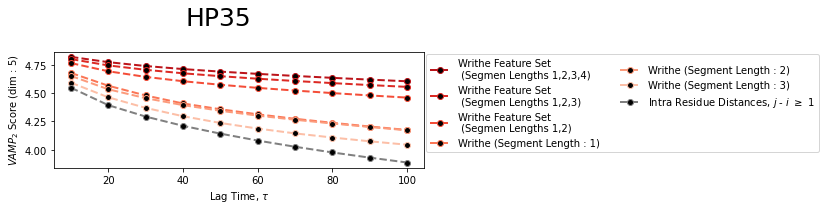

In [136]:
fig,ax=plt.subplots(1,figsize=(6,3))
from cycler import cycler


ax.set_prop_cycle((cycler(color=visualize.get_color_list(6,"Reds_r",trunc=60,pre_trunc=50)
                         )))

ax.plot(lags,np.power(combined_tcca_scores_1234, 2).sum(-1),
         label=f"Writhe Feature Set\n (Segmen Lengths 1,2,3,4)",
         lw=2,
         ls="--",
         marker="o",
         mfc="black")

ax.plot(lags,np.power(combined_tcca_scores_123, 2).sum(-1),
         label=f"Writhe Feature Set\n (Segmen Lengths 1,2,3)",
         lw=2,
         ls="--",
         marker="o",
         mfc="black")

ax.plot(lags,np.power(combined_tcca_scores_12, 2).sum(-1),
         label=f"Writhe Feature Set\n (Segmen Lengths 1,2)",
         lw=2,
         ls="--",
         marker="o",
         mfc="black")

for writhe_score, length in zip(writhe_scores.sum(-1),
                                      lengths[:num_len],
                                     ):   
    ax.plot(lags,writhe_score,
             label=f"Writhe (Segment Length : {length})",
             lw=2,
             ls="--",
             marker="o",
             mfc="black")
    
ax.plot(lags,distance_scores[0].sum(-1),
         label=f"Intra Residue Distances, $j$ - $i$ $\geq$ 1",
         color="gray",
         lw=2,
         ls="--",
         marker="o",
         mfc="black")
    
ax.set_ylabel("$VAMP_{2}$ Score (dim : 5)")
ax.set_xlabel(r"Lag Time, $\tau$")
#ax.set_title(f"Segment Length : {length}")
#ax.legend()

fig.suptitle(protein_name, fontsize=25, y=.96)

legend_elements = [Line2D([0], [0], color='indianred',
                          label="$Writhe$ Features | $Segment$ $Length_{k}$",
                          markersize=10, lw=2, ls="--"),
                   
                   Line2D([0], [0], color='gray',
                          label='Intra Residue Distances | $j$ - $i$ $\geq$ $Length_{k}$',
                          markersize=10, lw=2, ls="--")]

#fig.legend(handles=legend_elements,title=f"{5} Slowest Processes",loc="upper left",
          #fontsize=12, title_fontsize=15, edgecolor=(.5,.5,.5))

plt.tight_layout()
plt.subplots_adjust(top=.75)
fig.legend(ncol=2,bbox_to_anchor=(1.9,.76))
    
fig.suptitle(protein_name, fontsize=25, y=.96)

In [70]:
distance_tcca = utils.load_dict(distance_tcca_files[0])[35]

Text(0.05, 0.5, 'tCCA 2')

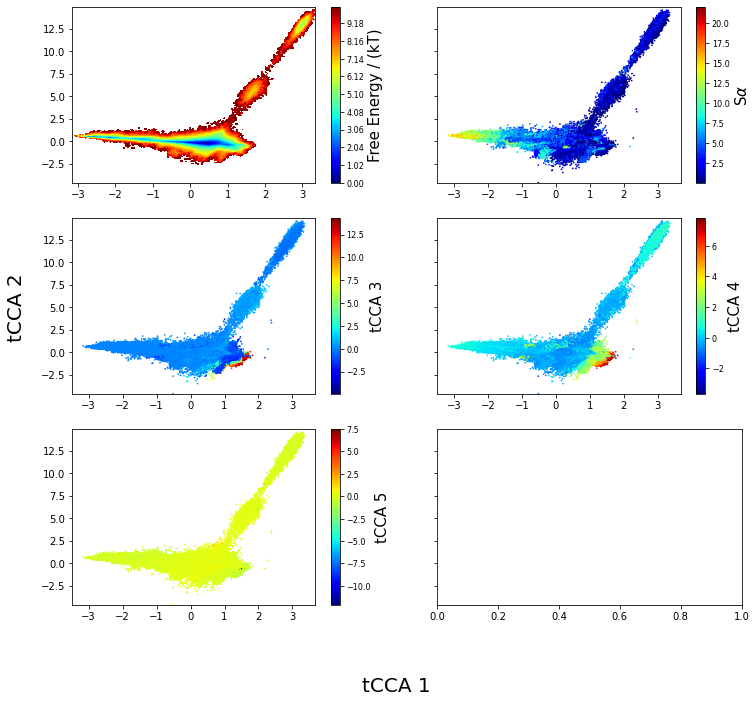

In [129]:
fig, axes = plt.subplots(3,2, figsize=(12, 11), sharey=True)
ax=axes.flat
lag_index = 1
visualize.fes2d(combined_tcca_1234[lag_index],
                ax=ax[0],
                comp_type="tCCA",
                x_label="")

visualize.proj2d(combined_tcca_1234[lag_index],
                 c=sa.sum(-1),
                 ax=ax[1],
                 cbar_label=r"S$\alpha$",
                 x_label="",
                 y_label="")

visualize.proj2d(combined_tcca_1234[lag_index],
                 c=combined_tcca_1234[lag_index][...,2],
                 ax=ax[2],
                 cbar_label="tCCA 3",
                 x_label="",
                 y_label="")

visualize.proj2d(combined_tcca_1234[lag_index],
                 c=combined_tcca_1234[lag_index][...,3],
                 ax=ax[3],
                 cbar_label="tCCA 4",
                 x_label="",
                 y_label="")

visualize.proj2d(combined_tcca_1234[lag_index],
                 c=combined_tcca_1234[lag_index][...,4],
                 ax=ax[4],
                 cbar_label="tCCA 5",
                 x_label="",
                 y_label="")


fig.supxlabel("tCCA 1", size=20)
fig.supylabel("tCCA 2", size=20, x=.05)

In [148]:
n_clusters = 30

dtraj, frames_cl = Kmeans(combined_tcca_1234[lag_index], n_clusters, 4)

dist_dtraj, dist_frames_cl = Kmeans(distance_tcca, n_clusters, 3)

pop_idx, counts = utils.sort_idx_list_obs(indices_list=frames_cl,
                                          obs=np.ones(len(dtraj)),
                                          stat=len,
                                          ret_stat=True).values()

populations=np.round(100*counts/len(dtraj),2)
sa = calc_sa(trj, f"{out_dir}/hp35_helix.pdb")
sa_frames_cl, sa_cl_idx, sa_cl_mean = utils.sort_idx_list_obs(indices_list=frames_cl,
                                                              obs=sa.sum(1),
                                                              sort_indices=True,
                                                              ret_stat=True).values()

In [149]:
msm=MarkovModel(dtraj).estimate_msm(40)
dist_msm=MarkovModel(dist_dtraj).estimate_msm(40)

Text(0.5, 1.12, 'HP35')

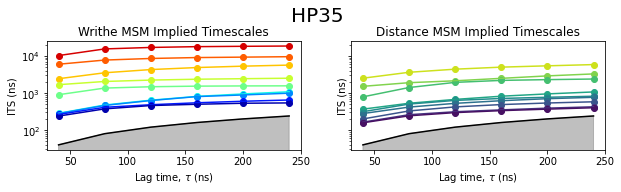

In [150]:
fig,axes = plt.subplots(1,2, figsize=(10,2), sharey=True)
ax = axes.flat
msm.its("msm", cmap="jet", ax=ax[0], n_its=9)
ax[0].set_title("Writhe MSM Implied Timescales")
dist_msm.its("msm", ax=ax[1], n_its=9)
ax[1].set_title("Distance MSM Implied Timescales")
fig.suptitle("HP35", y=1.12, size = 20)

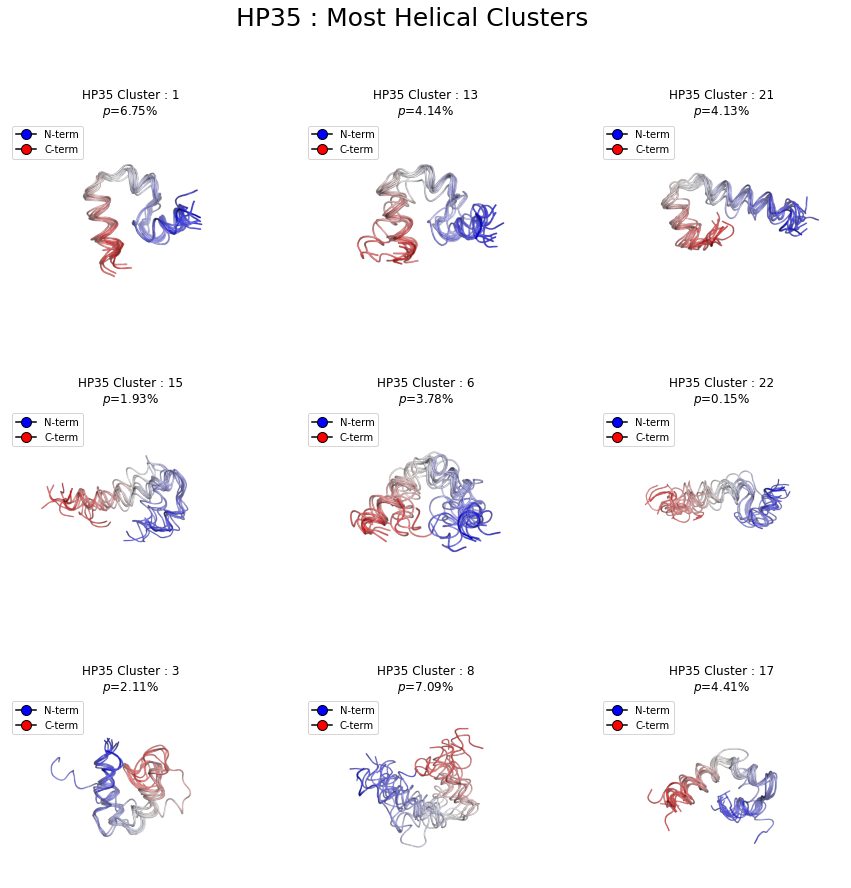

In [157]:
n_closest = 10
palette = "blue_gray90_red"
nterm_color = palette.split("_")[0]
cterm_color = palette.split("_")[-1]

fig, axes  = plt.subplots(3,3,figsize=(15,15))
fig.suptitle(f"{protein_name} : Most Helical Clusters", fontsize=25, y=.96)

for i, salpha, pop, ax, indices in zip(sa_cl_idx,
                                      sa_cl_mean[sa_cl_idx],
                                      populations[sa_cl_idx],
                                      axes.flat, 
                                      list(map(sa_frames_cl.__getitem__, sa_cl_idx))):
    

    
    image = visualize.make_structures(trj=trj.center_coordinates(),
                                      indices=indices[:n_closest],
                                      dir=f"{out_dir}/images",
                                      ensemble=True,
                                      name = i,
                                      overwrite=True,
                                      transparency=.2,
                                      palette=palette,
                                      ref=pdb)

    visualize.plot_structure(image,
                             title = (f"{protein_name} Cluster : {i+1}\n"
                                      rf"$p$={pop}%"),
                             ax=ax)
    
    


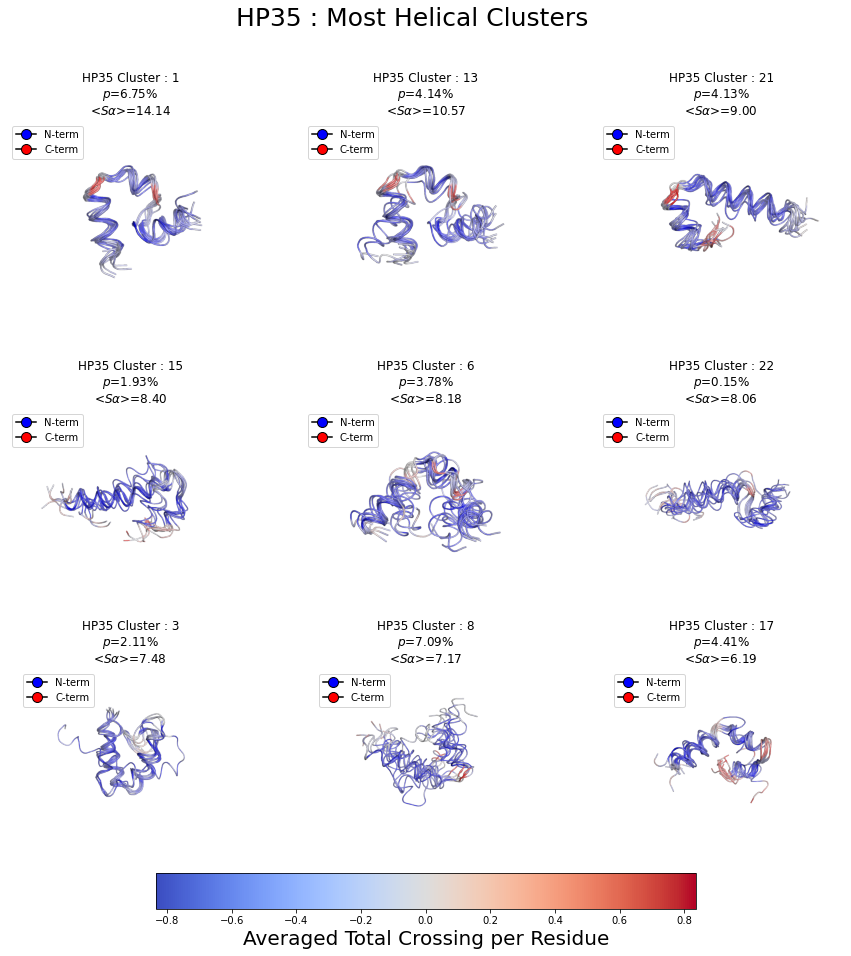

In [156]:
n_closest = 10
palette = "blue_gray90_red"
nterm_color = palette.split("_")[0]
cterm_color = palette.split("_")[-1]

fig, axes  = plt.subplots(3,3,figsize=(15,15))
fig.suptitle(f"{protein_name} : Most Helical Clusters", fontsize=25, y=.96)

for i, salpha, pop, ax, indices in zip(sa_cl_idx,
                                      sa_cl_mean[sa_cl_idx],
                                      populations[sa_cl_idx],
                                      axes.flat, 
                                      list(map(sa_frames_cl.__getitem__, sa_cl_idx))):
    

    
    beta_values = to_writhe_adj_matrix(np.load(writhe_data_files[1])[indices[:n_closest]],
                                       len(residues),
                                       2).mean(0).sum(0)
    
    abs_max = max((beta_values.max(), abs(beta_values).max()))
    
    image = visualize.make_structures(trj=trj.center_coordinates(),
                                      indices=indices[:n_closest],
                                      dir=f"{out_dir}/images",
                                      ensemble=True,
                                      name = i,
                                      overwrite=True,
                                      transparency=.2,
                                      palette=palette,
                                      ref=pdb,
                                      beta_values=beta_values,
                                      beta_min=-abs_max,
                                      beta_max=abs_max)

    visualize.plot_structure(image,
                             title = (f"{protein_name} Cluster : {i+1}\n"
                                      rf"$p$={pop}%"
                                      "\n"
                                      rf"<$S\alpha$>={salpha:.2f}"),
                             ax=ax)
    
norm = matplotlib.colors.Normalize(vmin=-1, vmax=1)
cbar = fig.colorbar(im, ax=[axes[-1,i] for i in range(3)],
                    cmap=key, norm=norm, 
                    orientation = "horizontal",
                    aspect=15)

cbar.set_label("Averaged Total Crossing per Residue", size = 20) 
plt.show()
    


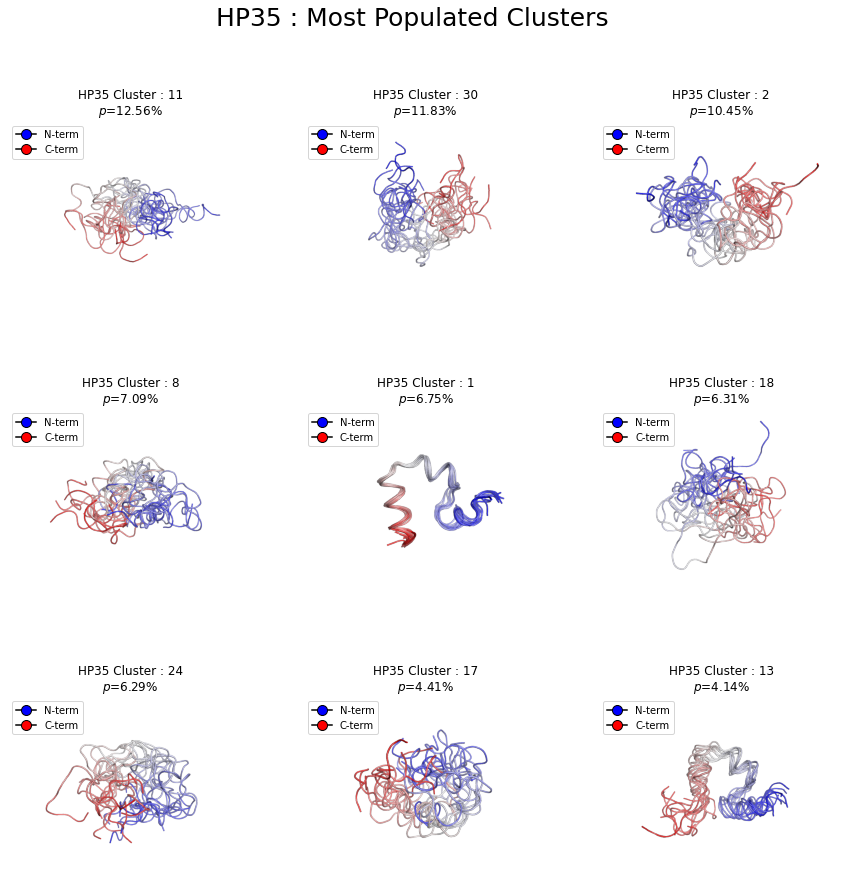

In [166]:
n_closest = 10
palette = "blue_gray90_red"
nterm_color = palette.split("_")[0]
cterm_color = palette.split("_")[-1]


fig, axes  = plt.subplots(3,3,figsize=(15,15))
fig.suptitle(f"{protein_name} : Most Populated Clusters", fontsize=25, y=.96)
for i, pop, ax, indices in zip(pop_idx,
                               populations[pop_idx],
                               axes.flat, 
                               list(map(frames_cl.__getitem__, pop_idx)),
                              ):
    
                                       
    image = visualize.make_structures(trj=trj.center_coordinates(),
                                      indices=indices[:n_closest],
                                      dir=f"{out_dir}/images",
                                      ensemble=True,
                                      name = i,
                                      overwrite=True,
                                      transparency=.2,
                                      ref=pdb)

    im=visualize.plot_structure(image,
                                title = (f"{protein_name} Cluster : {i+1}\n"
                                         rf"$p$={pop}%"),
                                ax=ax)
    


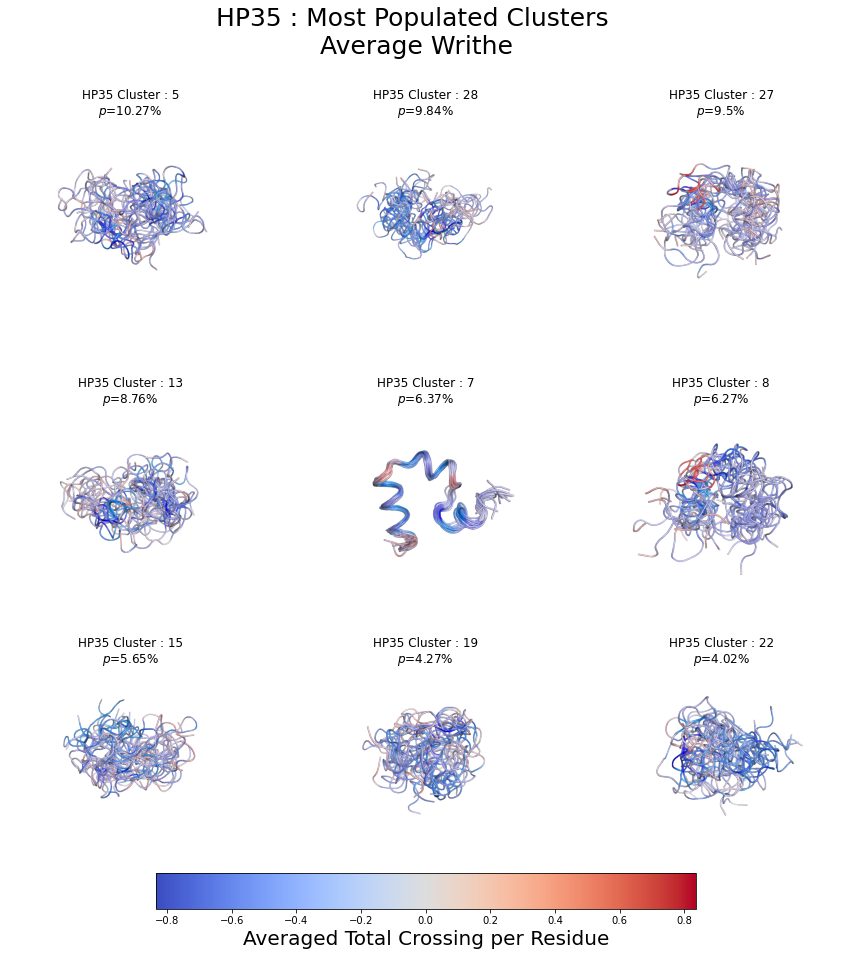

In [139]:
n_closest = 15
key = "coolwarm"

fig, axes  = plt.subplots(3,3,figsize=(15,15))
fig.suptitle(f"{protein_name} : Most Populated Clusters\n Average Writhe", fontsize=25, y=.96)
for i, pop, ax, indices in zip(pop_idx,
                               populations[pop_idx],
                               axes.flat, 
                               list(map(frames_cl.__getitem__, pop_idx)),
                              ):

    beta_values = to_writhe_adj_matrix(np.load(writhe_data_files[2])[indices[:n_closest]],
                                       len(residues),
                                       2).mean(0).sum(0)    
    
    abs_max = max((beta_values.max(), abs(beta_values).max()))
    
    image = visualize.make_structures(trj=trj.center_coordinates(),
                                      indices=indices[:n_closest],
                                      dir=f"{out_dir}/images",
                                      ensemble=True,
                                      name = i,
                                      overwrite=True,
                                      transparency=.2,
                                      palette=visualize.palettes[key],
                                      ref=pdb,
                                      beta_values=beta_values,
                                      beta_min = -abs_max,
                                      beta_max = abs_max)

    im=visualize.plot_structure(image,
                                vmin=-abs_max,
                                vmax=abs_max,
                                legend=False,
                                cbar_label = "Ave. Total Total Writhe",
                                title = (f"{protein_name} Cluster : {i+1}\n"
                                      rf"$p$={pop}%"),
                                ax=ax)
    

norm = matplotlib.colors.Normalize(vmin=-1, vmax=1)
cbar = fig.colorbar(im, ax=[axes[-1,i] for i in range(3)],
                    cmap=key, norm=norm, 
                    orientation = "horizontal",
                    aspect=15)

cbar.set_label("Averaged Total Crossing per Residue", size = 20) 
plt.show()

/home/t/writhe/package/visualize/visualize.py:256: RuntimeWarning: divide by zero encountered in log
  F = -np.log(arr)


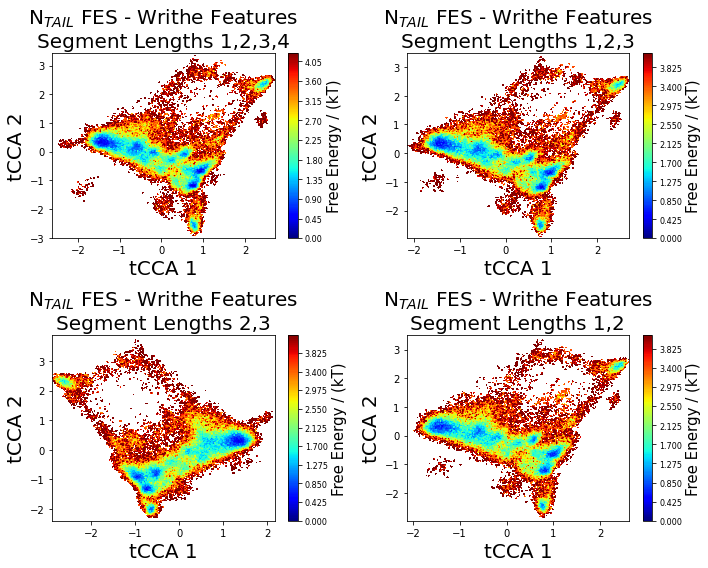

In [12]:
fig, axes = plt.subplots(2,2,figsize=(10,8))

for ax, (key, value) in zip(axes.flat, writhe_feature_sets.items()):
    visualize.fes2d(
                    value["proj"],
                    title = (f"{protein_name} FES - Writhe Features\n"
                    f"Segment Lengths {','.join(list(iter(key)))}"),
                    x_label="tCCA 1", y_label="tCCA 2",
                    ax=ax,
                    bins=250)
    
plt.tight_layout()

 # Let's project the writhe and distance data onto the dominant singular functions of their Koopman matrices

In [13]:
feat_idx = "1234"
distance_projection = tCCA(
   distances[:,utils.triu_flat_indices(len(residues),1,2)], proj_lag).fit_transform(dim=proj_lag)

Text(0.48, 1, 'N$_{TAIL}$')

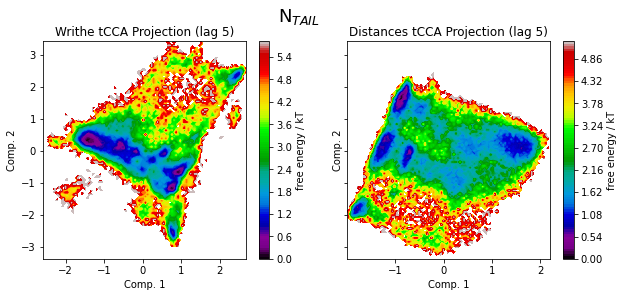

In [14]:
import pyemma
fig,axes=plt.subplots(1,2, sharey=True,figsize=(10,4))
for ax,name,data in zip(axes.flat, 
                        "Writhe,Distances".split(","),
                        [writhe_feature_sets[feat_idx]["proj"],
                        distance_projection]
                       ):
    
    ax.set_xlabel("Comp. 1")
    ax.set_ylabel("Comp. 2")
    ax.set_title(f"{name} tCCA Projection (lag {proj_lag})")
    pyemma.plots.plot_free_energy(*data[:,:2].T,ax=ax )
fig.suptitle(protein_name, fontsize=18, y=1,x=.48)

 # Clustering

In [15]:
n_clusters = 30
dtraj, frames_cl = Kmeans(writhe_feature_sets[feat_idx]["proj"], n_clusters, proj_dim)

pop_idx, counts = utils.sort_idx_list_obs(indices_list=frames_cl,
                                    obs=np.ones(trj.n_frames),
                                    stat=len,
                                    ret_stat=True).values()

populations=np.round(100*counts/trj.n_frames,2)
sa = calc_sa(trj, md.load("./Ntail.helix.pdb"))
sa_frames_cl, sa_cl_idx, sa_cl_mean = utils.sort_idx_list_obs(indices_list=frames_cl,
                                                              obs=sa.sum(1),
                                                              sort_indices=True,
                                                              ret_stat=True).values()


/home/t/writhe/package/visualize/visualize.py:256: RuntimeWarning: divide by zero encountered in log
  F = -np.log(arr)


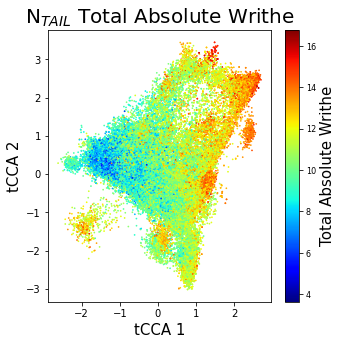

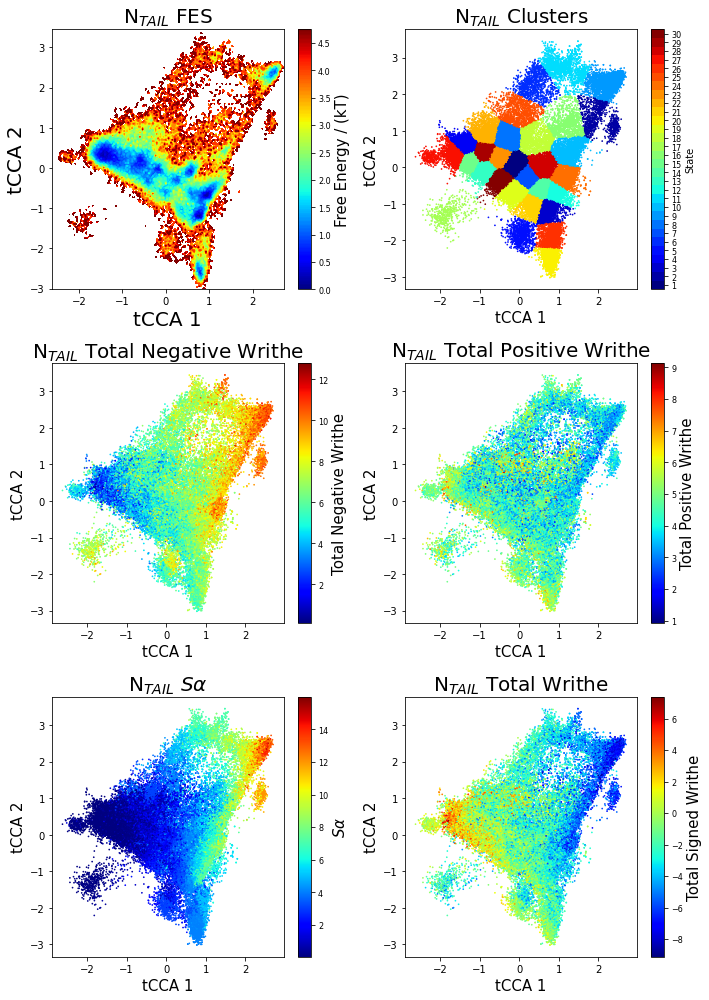

In [16]:
# set the le`ngth to use for projections
len_idx=2

#plot the total absolute writhe
visualize.proj2d(writhe_feature_sets[feat_idx]["proj"],
                 abs(writhe_datasets[len_idx]["data"]).sum(1),
                 title = f"{protein_name} Total Absolute Writhe",
                 x_label="tCCA 1", y_label="tCCA 2",
                 cbar_label="Total Absolute Writhe",)


#subplot for state map, FES, variations of writhe
fig, axes = plt.subplots(3,2,figsize=(10,14))
ax=axes.flat

visualize.fes2d(writhe_feature_sets[feat_idx]["proj"],
     title = f"{protein_name} FES",
     x_label="tCCA 1", y_label="tCCA 2",
     ax=ax[0])


visualize.proj2d(writhe_feature_sets[feat_idx]["proj"],
                 dtraj, state_map=True,
                 title = f"{protein_name} Clusters",
                 x_label="tCCA 1", y_label="tCCA 2",
                 ax=ax[1])


visualize.proj2d(writhe_feature_sets[feat_idx]["proj"],
                 -1*np.where(writhe_datasets[len_idx]["data"]<=0,
                          writhe_datasets[len_idx]["data"],0).sum(1),
                 title = f"{protein_name} Total Negative Writhe",
                 x_label="tCCA 1", y_label="tCCA 2",
                 cbar_label="Total Negative Writhe",
                 ax=ax[2])


visualize.proj2d(writhe_feature_sets[feat_idx]["proj"],
                 np.where(writhe_datasets[len_idx]["data"]>=0,
                          writhe_datasets[len_idx]["data"],0).sum(1),
                 title = f"{protein_name} Total Positive Writhe",
                 x_label="tCCA 1", y_label="tCCA 2",
                 cbar_label="Total Positive Writhe",
                 ax=ax[3])



visualize.proj2d(writhe_feature_sets[feat_idx]["proj"], sa.sum(1),
                 title = rf"{protein_name} $S\alpha$",
                 x_label="tCCA 1", y_label="tCCA 2",
                 cbar_label=r"$S\alpha$",
                 ax=ax[4])

visualize.proj2d(writhe_feature_sets[feat_idx]["proj"],
                 writhe_datasets[len_idx]["data"].sum(1),
                 title = f"{protein_name} Total Writhe",
                 x_label="tCCA 1", y_label="tCCA 2",
                 cbar_label="Total Signed Writhe",
                 ax=ax[5])
plt.tight_layout()

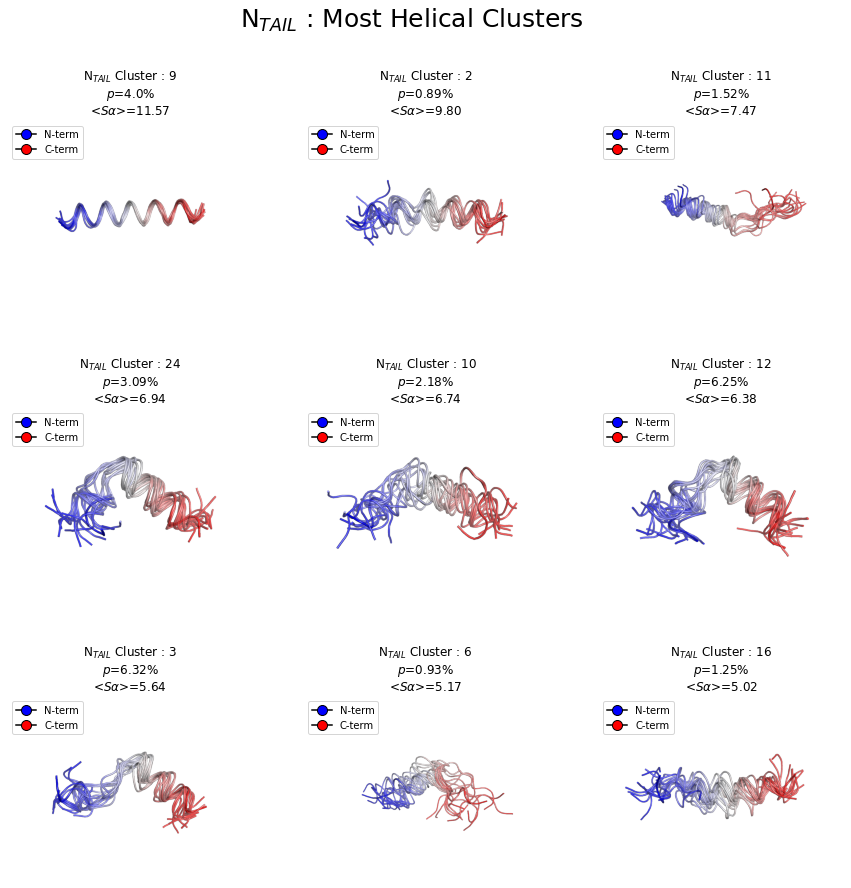

In [17]:
n_closest = 15
palette = "blue_gray90_red"
nterm_color = palette.split("_")[0]
cterm_color = palette.split("_")[-1]

fig, axes  = plt.subplots(3,3,figsize=(15,15))
fig.suptitle(f"{protein_name} : Most Helical Clusters", fontsize=25, y=.96)
for i,salpha, pop, ax, indices in zip(sa_cl_idx,
                                      sa_cl_mean[sa_cl_idx],
                                      populations[sa_cl_idx],
                                      axes.flat, 
                                      list(map(sa_frames_cl.__getitem__, sa_cl_idx)),
                               ):

    image = visualize.make_structures(trj=trj.center_coordinates(),
                                      indices=indices[:n_closest],
                                      dir=f"{out_dir}/images",
                                      ensemble=True,
                                      name = i,
                                      overwrite=True,
                                      transparency=.2,
                                      palette=palette,
                                      ref=pdb)

    visualize.plot_structure(image,
                             nterm_color=nterm_color,
                             cterm_color =cterm_color,
                             title = (f"{protein_name} Cluster : {i+1}\n"
                                      rf"$p$={pop}%"
                                      "\n"
                                      rf"<$S\alpha$>={salpha:.2f}"),
                             ax=ax)
    


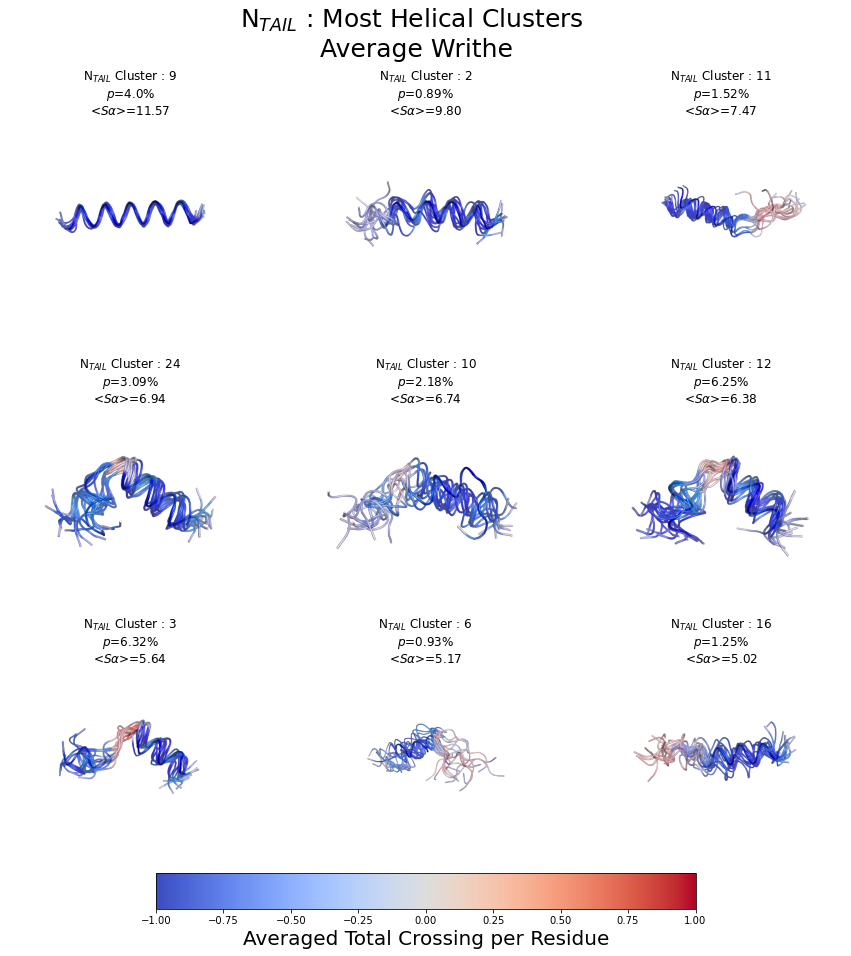

In [18]:
n_closest = 15
nterm_color = palette.split("_")[0]
cterm_color = palette.split("_")[-1]
key = "coolwarm" # corresponds to a key in the visualize.palettes which is a spectral coloring in pymol


fig, axes  = plt.subplots(3,3,figsize=(15,15))
fig.suptitle(f"{protein_name} : Most Helical Clusters\n Average Writhe", fontsize=25, y=.96)
for i, salpha, pop, ax, indices in zip(sa_cl_idx,
                               sa_cl_mean[sa_cl_idx],
                               populations[sa_cl_idx],
                               axes.flat, 
                               list(map(sa_frames_cl.__getitem__, sa_cl_idx))):

    beta_values = to_writhe_adj_matrix(
        writhe_datasets[len_idx]["data"][indices[:n_closest]], 21, len_idx).mean(0).sum(0)
    
    
    image = visualize.make_structures(trj=trj.center_coordinates(),
                                      indices=indices[:n_closest],
                                      dir=f"{out_dir}/images",
                                      ensemble=True,
                                      name = i,
                                      overwrite=True,
                                      transparency=.2,
                                      palette=visualize.palettes[key],
                                      ref=pdb,
                                      beta_values=beta_values,
                                      beta_min = -1,
                                      beta_max = 1)

    im=visualize.plot_structure(image,
                                cbar=False,
                                cmap=key,
                                vmin=-1,
                                vmax=1,
                                legend=False,
                                cbar_label = None,
                                title = (f"{protein_name} Cluster : {i+1}\n"
                                      rf"$p$={pop}%"
                                      "\n"
                                      rf"<$S\alpha$>={salpha:.2f}"),
                                ax=ax)
    
    
cmap = getattr(plt.cm, "coolwarm")
norm = matplotlib.colors.Normalize(vmin=-1, vmax=1)
cbar = fig.colorbar(im, ax=[axes[-1,i] for i in range(3)],
                    cmap="coolwarm", norm=norm, 
                    orientation = "horizontal",
                    aspect=15)

cbar.set_label("Averaged Total Crossing per Residue", size = 20) 
plt.show()

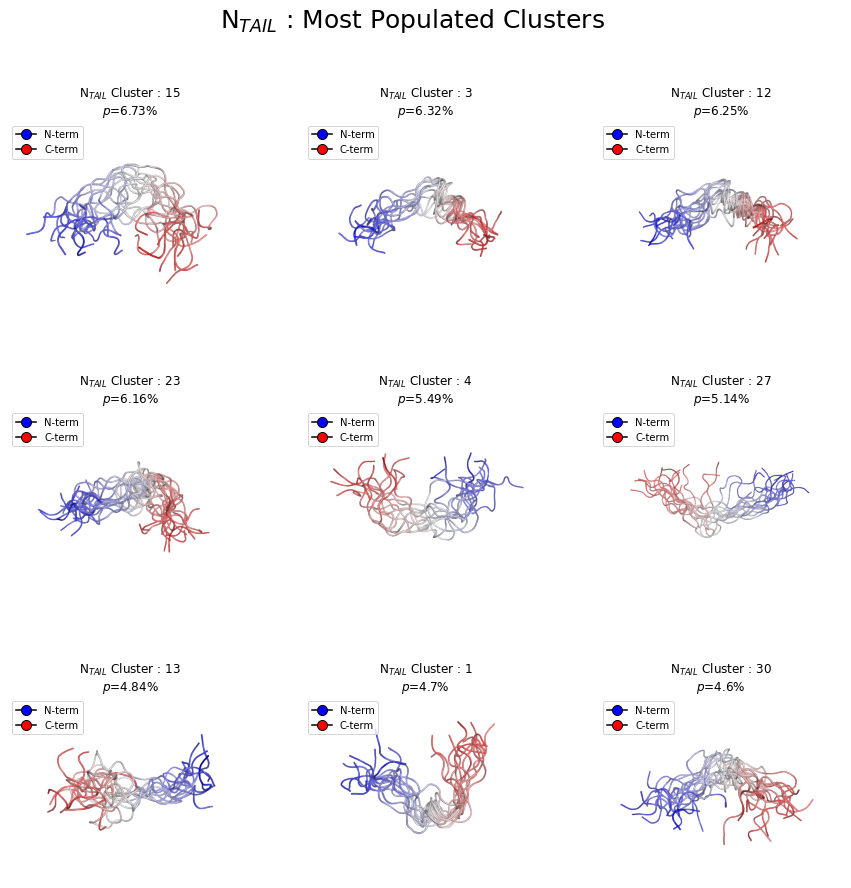

In [20]:
n_closest = 15
palette = "blue_gray90_red"
nterm_color = palette.split("_")[0]
cterm_color = palette.split("_")[-1]

fig, axes  = plt.subplots(3,3,figsize=(15,15))
fig.suptitle(f"{protein_name} : Most Populated Clusters", fontsize=25, y=.96)
for i, pop, ax, indices in zip(pop_idx,
                               populations[pop_idx],
                               axes.flat, 
                               list(map(frames_cl.__getitem__, pop_idx)),
                              ):

    image = visualize.make_structures(trj=trj.center_coordinates(),
                                      indices=indices[:n_closest],
                                      dir=f"{out_dir}/images",
                                      ensemble=True,
                                      name = i,
                                      overwrite=True,
                                      transparency=.2,
                                      palette=palette,
                                      ref=pdb)

    visualize.plot_structure(image,
                             nterm_color=nterm_color,
                             cterm_color =cterm_color,
                             title = (f"{protein_name} Cluster : {i+1}\n"
                                      rf"$p$={pop}%"),
                             ax=ax)
    

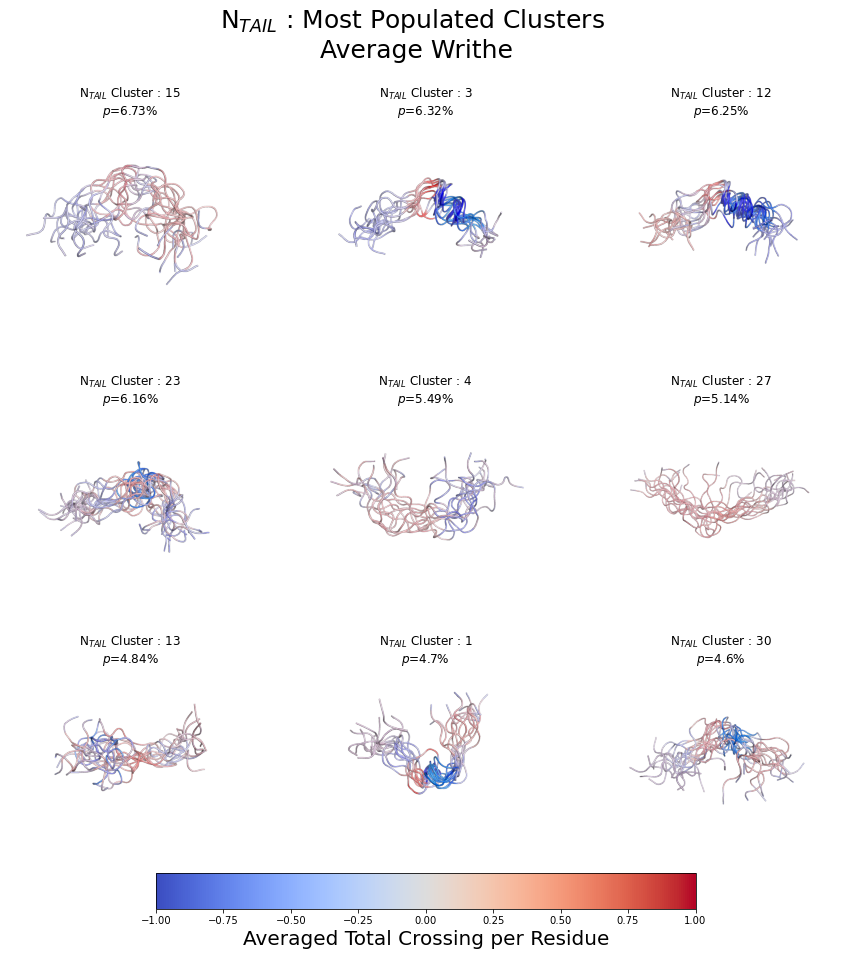

In [22]:
n_closest = 15
nterm_color = palette.split("_")[0]
cterm_color = palette.split("_")[-1]
key = "coolwarm"


fig, axes  = plt.subplots(3,3,figsize=(15,15))
fig.suptitle(f"{protein_name} : Most Populated Clusters\n Average Writhe", fontsize=25, y=.96)
for i, pop, ax, indices in zip(pop_idx,
                               populations[pop_idx],
                               axes.flat, 
                               list(map(frames_cl.__getitem__, pop_idx)),
                              ):

    beta_values = to_writhe_adj_matrix(
        writhe_datasets[len_idx]["data"][indices[:n_closest]], 21, len_idx).mean(0).sum(0)
    
    
    image = visualize.make_structures(trj=trj.center_coordinates(),
                                      indices=indices[:n_closest],
                                      dir=f"{out_dir}/images",
                                      ensemble=True,
                                      name = i,
                                      overwrite=True,
                                      transparency=.2,
                                      palette=visualize.palettes[key],
                                      ref=pdb,
                                      beta_values=beta_values,
                                      beta_min = -1,
                                      beta_max = 1)

    im=visualize.plot_structure(image,
                                vmin=-1,
                                vmax=1,
                                legend=False,
                                cbar_label = "Ave. Total Total Writhe",
                                title = (f"{protein_name} Cluster : {i+1}\n"
                                      rf"$p$={pop}%"),
                                ax=ax)
    

norm = matplotlib.colors.Normalize(vmin=-1, vmax=1)
cbar = fig.colorbar(im, ax=[axes[-1,i] for i in range(3)],
                    cmap=key, norm=norm, 
                    orientation = "horizontal",
                    aspect=15)

cbar.set_label("Averaged Total Crossing per Residue", size = 20) 
plt.show()

In [23]:
msm=MarkovModel(dtraj).estimate_msm(lag = 5, steps=5).estimate_hmm(5).estimate_pcca(5)

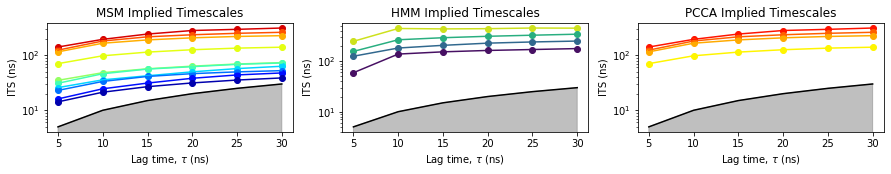

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [24]:
fig, axes = plt.subplots(1,3, figsize=(15,2))
cmaps = ["jet", "viridis", "autumn_r"]
for model, ax, cmap in zip("msm,hmm,pcca".split(","), axes.flat, cmaps):
    if model == "msm":
        n_its = 10
    else:
        n_its = None
    plt.figure()
    msm.its(model_type= model,
            ax=ax,
            n_its = n_its, 
            cmap=cmap)
plt.tight_layout()

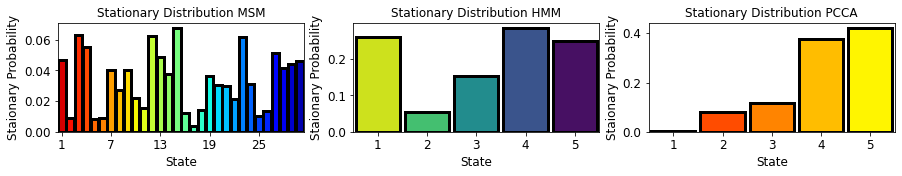

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [25]:
fig, axes = plt.subplots(1,3, figsize=(15,2))
for model, ax,cmap in zip("msm,hmm,pcca".split(","), axes.flat, cmaps):
    plt.figure()
    if model == "msm":
        state_label_stride = 6
    else:
        state_label_stride = 1
    msm.stationary_distribution(model_type= model,
                                ax=ax,
                                cmap=cmap,
                                state_label_stride=state_label_stride)
plt.tight_layout()

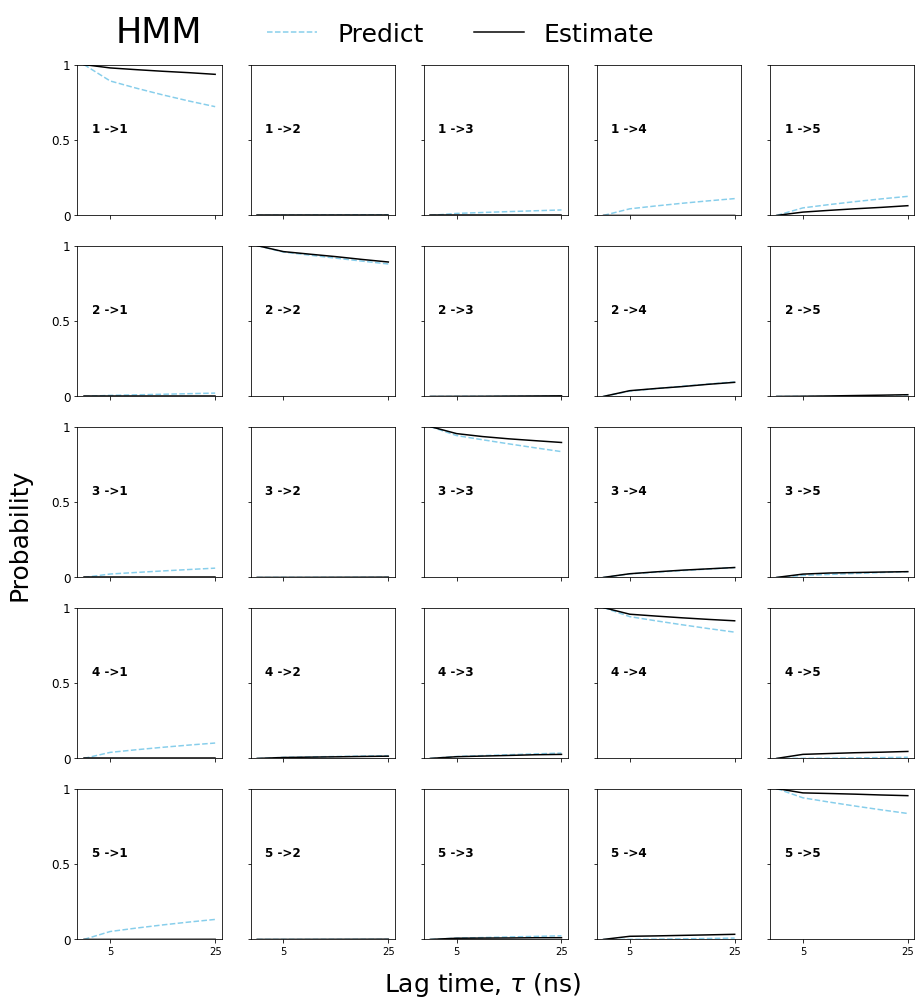

In [26]:
msm.reindex_msm
msm.cktest("hmm", predict_color = "skyblue")

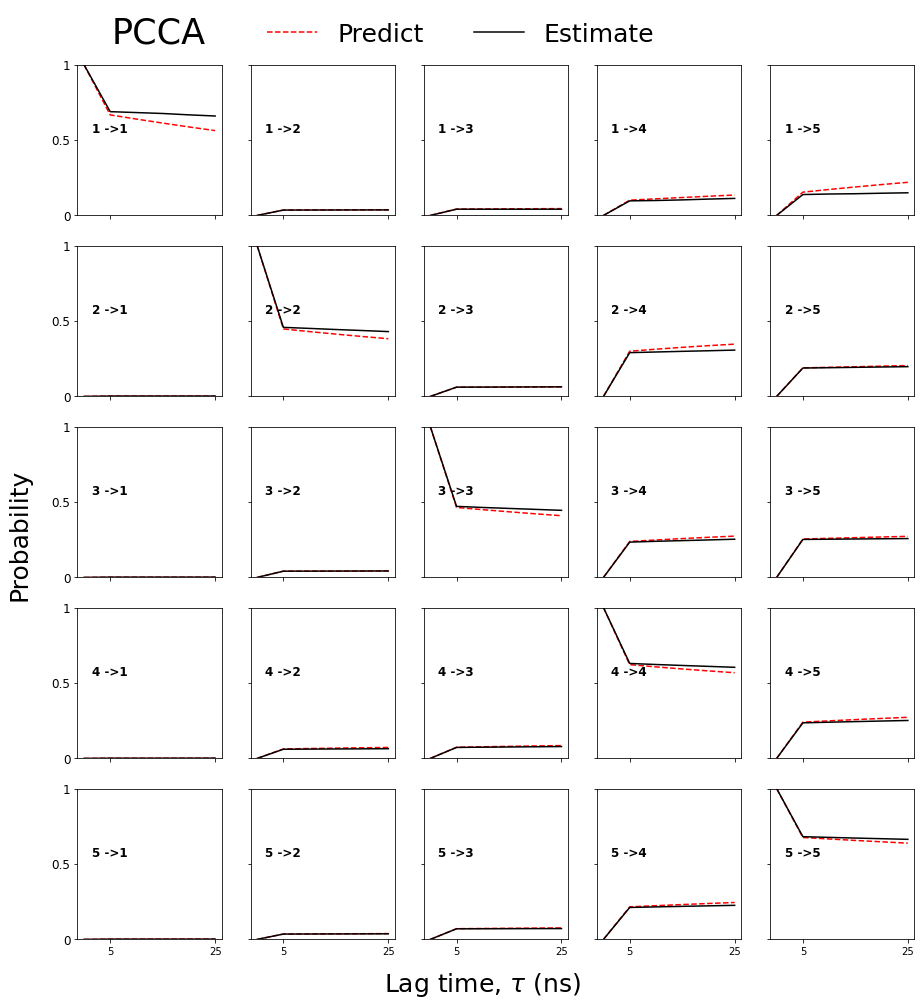

In [27]:
msm.cktest("pcca")

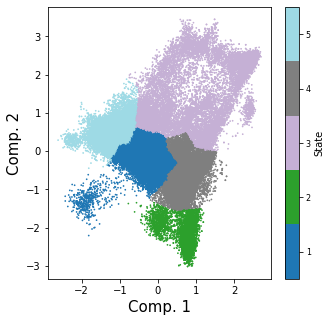

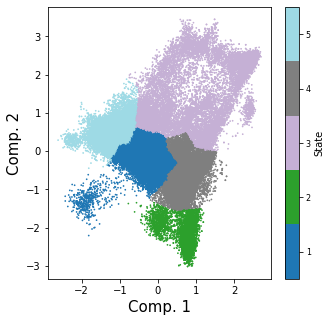

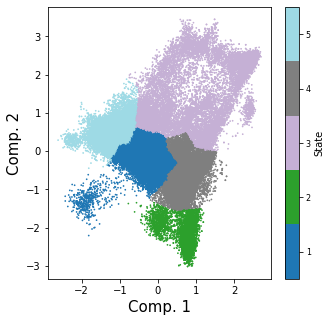

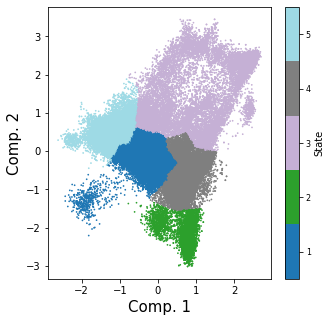

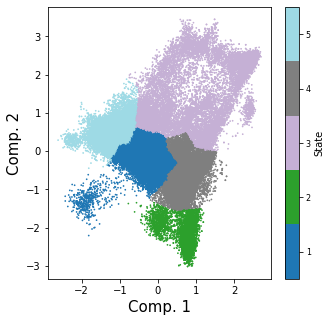

In [26]:
msm.reindex_msm(model_type = "hmm")
for i in range(5):
    visualize.proj2d(writhe_feature_sets[feat_idx]["proj"],
                     c = msm.hmm["data"]["dtrajs"][0],
                     state_map=True,
                     cmap="tab20")

 # Let's try a geometrically perfect helix

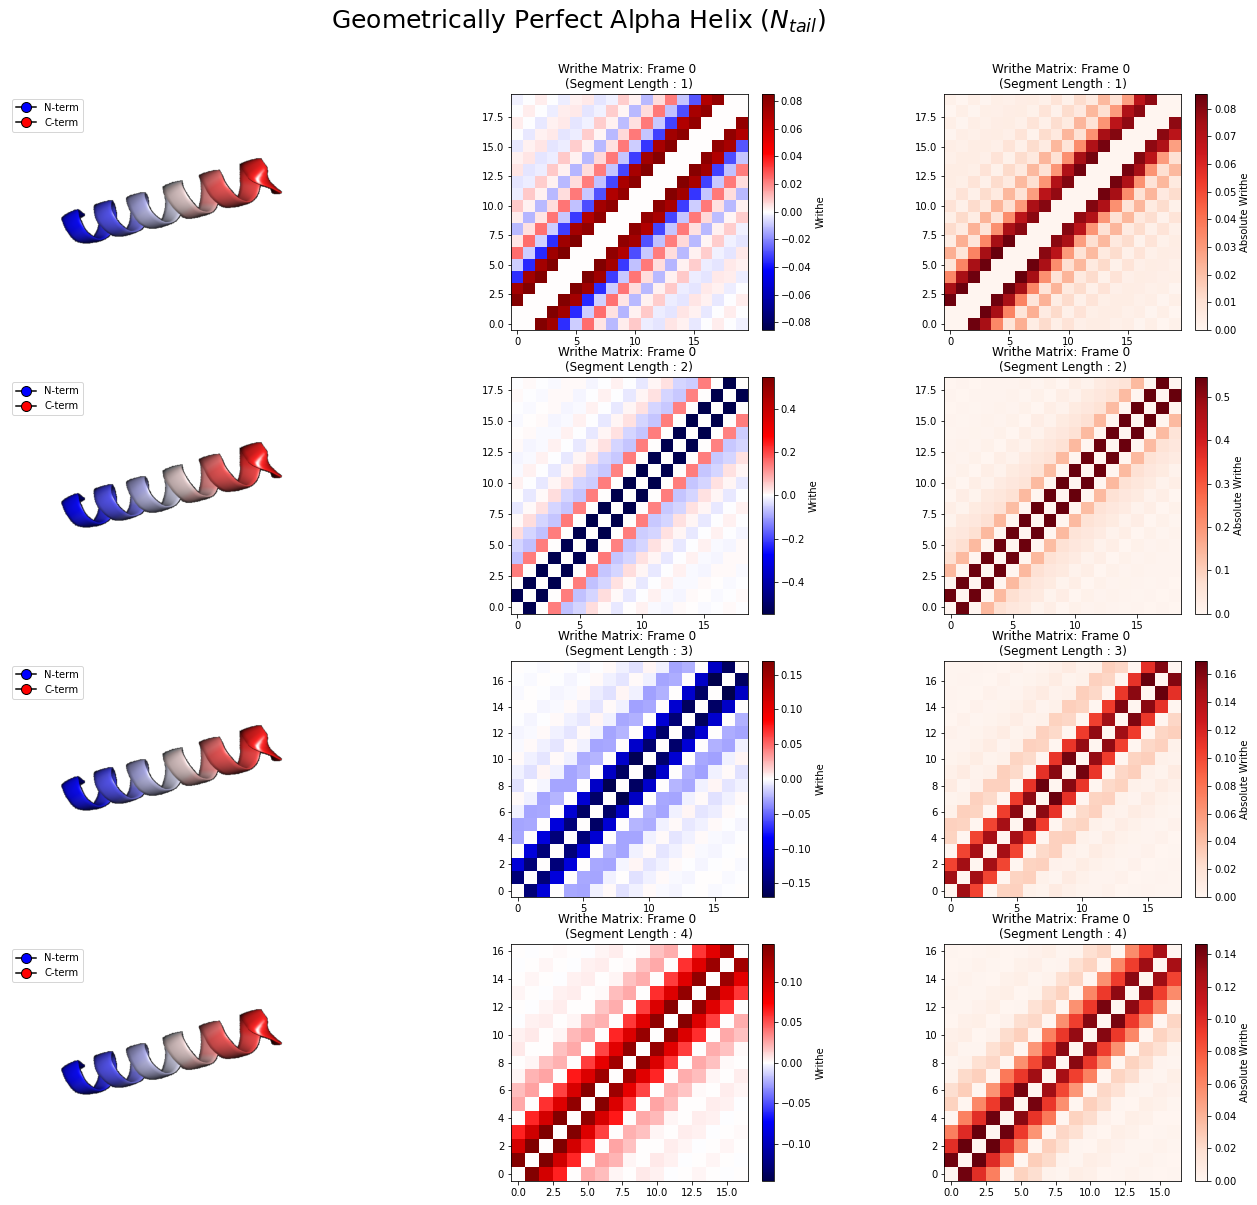

In [17]:
helix = md.load("./Ntail.helix.pdb")
#get CA coords
xyz_helix = helix.atom_slice(helix.topology.select("name CA")).xyz
#instantiate writhe class
writhe_helix = Writhe(xyz_helix)
#compute writhe at segment length : 4 (uses parallelization over the cpu cores)

fig,axes=plt.subplots(4,3, figsize=(22,20))
structure=visualize.make_structures(trj=helix, indices=0, dir="./ntail_helix/images")

fig.suptitle('Geometrically Perfect Alpha Helix ($N_{tail}$)', fontsize=25, y=.94)
for ax, segment_length in zip(axes, [1,2,3,4]):
    writhe_data = writhe_helix.compute_writhe(length = segment_length,
                                matrix = True,
                                store_results = True,
                                return_segments=False,
                                adj_matrix=False)
    visualize.plot_structure(image=structure, ax=ax[0])
    writhe_helix.plot_writhe_matrix(index=0, ax=ax[1])
    writhe_helix.plot_writhe_matrix(index=0, ax=ax[2], absolute=True)

 # Make Graph Representations For All Frames of The Trajectory

In [7]:
#make instance of writhe graph
graph = WritheGraph(trj)

#add edge features
graph.add_dihedrals() #0,1
graph.add_angles() #2,3
graph.add_intra_distances() #4
graph.add_writhe(segment_length = 1) #5
graph.add_writhe(segment_length = 3) #6
graph.add_writhe(segment_length = 5) #7

#add node_features
#graph.add_ligand_distances() #0
graph.add_dssp() #1
graph.add_rsa() #2

#set up
graph.make_edge_dict()

In [8]:
#make a graph for each frame
graphs = [graph.get_graph(i) for i in range(graph.nf)]

#set a directory to save to
root="./actr/graphs"
os.mkdir(root)

# GraphDataSet class collates all graph examples into one giant graph
# and stores them for efficient access during training

graph_dataset = GraphDataSet(root=root, name="graph", data_list=graphs)

Processing...
Done!


Text(0.5, 1.0, '$N_{tail}$ Helical Propensity')

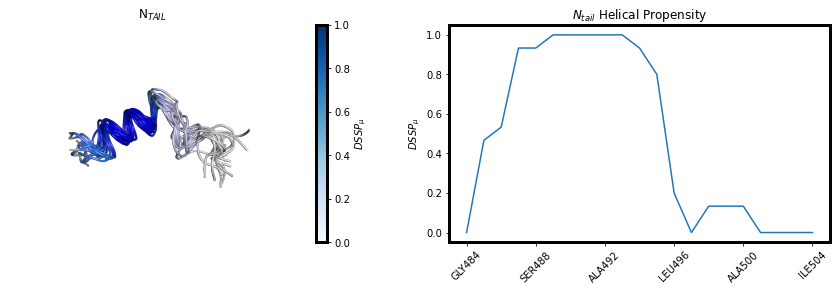

In [94]:
beta_values = np.where(md.compute_dssp(trj)=="H", 1, 0).mean(0)
key = "Blues"

start = 110
indices = np.arange(start,start+15)
beta_values = np.where(md.compute_dssp(trj)=="H",1,0)[indices].mean(0)

image = visualize.make_structures(trj=trj.center_coordinates(),
                                  indices= indices,
                                  dir=f"{out_dir}/images",
                                  ensemble=True,
                                  name = "test",
                                  overwrite=True,
                                  transparency=.1,
                                  ref=pdb,
                                  beta_values=beta_values,
                                  palette = visualize.palettes[key],
                          
                                  )

fig, axes = plt.subplots(1,2, figsize = (15,4))
ax = axes.flat
visualize.plot_structure(image, title = f"{protein_name}", 
                         cmap = key,
                         vmin=beta_values.min(),
                         vmax=beta_values.max(),
                         cbar_label=r"$DSSP_{\mu}$",
                         ax = ax[0])
ax[1].plot(beta_values)
ax[1].set_xticks(np.arange(0,21,4))
_=ax[1].set_xticklabels(residues[::4], rotation=45)
ax[1].set_ylabel(r"$DSSP_{\mu}$")
ax[1].set_title(r"$N_{tail}$ Helical Propensity")